In [2]:
# Variable that changes some settings according to whether the notebook is run on Jupyter or Colab

working_on = 'Jupyter'

# Importing and installing libraries

## Cudf installation (only on Colab)

In [2]:
# pyarrow update (necessary to avoid an error that arises when importing cudf)

! pip install pyarrow --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [3]:
# Cudf installation

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 438 (delta 121), reused 57 (delta 54), pack-reused 269
Receiving objects: 100% (438/438), 118.31 KiB | 1.21 MiB/s, done.
Resolving deltas: 100% (223/223), done.
***********************************************************************
We will now install RAPIDS via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.2/955.2 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 889.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

if working_on == 'Colab':
    import cudf
    %load_ext cudf.pandas

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from scipy import stats
from scipy.stats.mstats import winsorize

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

In [4]:
if working_on == 'Jupyter':

    path_tesi_folder = 'C:/Users/federico/Desktop/Magistrale DSBA/Tesi/Dati'
    path_v1 = path_tesi_folder + '/Dati finali 2022/v1'
    path_v2 = path_tesi_folder + '/Dati finali 2022/v2'
    path_v3 = path_tesi_folder + '/Dati finali 2022/v3'

elif working_on == 'Colab':

    from google.colab import drive
    drive.mount('/content/drive')

    path_tesi_folder = '/content/drive/MyDrive/Tesi/Dati'
    path_v1 = path_tesi_folder + '/Dati finali 2022/v1'
    path_v2 = path_tesi_folder + '/Dati finali 2022/v2'
    path_v3 = path_tesi_folder + '/Dati finali 2022/v3'

else:
    raise Exception('Ops! Something wrong!')

# Useful functions

In [5]:
'''
set_types_columns: function that sets the right datatypes (either float64 or string) to the columns of the dataframe
'''
string_columns = ['Ragione sociale', 'Codice fiscale', 'Indirizzo sede legale - Regione', 'Stato giuridico',
                  'Categoria societaria', 'ATECO 2007\ncodice', 'ATECO 2007\ndescrizione', 'Attività principale']

def set_types_columns(df, string_columns):

    for col in df.columns:
        if col in string_columns:
            df[col] = df[col].astype('string')
        else:
            df[col] = df[col].astype('float64')

    return df

'''
remove_Unnamed_columns: function that removes the 'Unnamed' like columns at the beginning of the dataframe
'''
def remove_Unnamed_columns(df):

    cols_to_delete = [col for col in df.columns if col.startswith('Unnamed')]

    if len(cols_to_delete) != 0:
        df.drop(df.loc[:,cols_to_delete], axis=1, inplace=True)

    return df

In [6]:
'''
dictionary_missing_values: A function that takes in input a pandas dataframe and an axis and return a dictionary with the percentage
of missing values by the specified axis
Input:
- df: input dataframe
- axis along which control for missing values
Output:
- percentage_null_dict: dictionary of the form index:percentage of missings by axis
Other variables:
- length: length of the axis (for percentage calculation)
'''


def dictionary_missing_values(df, axis, percentage_or_number='Percentage'):

    if axis == 0:
        length = len(df)

    elif axis == 1:
        length = len(df.columns)

    else:
        raise Exception('Specified wrong axis!')

    percentage_null_dict = df.isnull().sum(axis=axis).sort_values(ascending=False).to_dict()

    if percentage_or_number == 'Percentage':

        return {key: value/length for key, value in percentage_null_dict.items()}

    elif percentage_or_number == 'Number':

        return percentage_null_dict

    else:

        raise Exception('Invalid parameter inserted!')


'''
filtered_df_per_missing_values: A function that takes in input a pandas dataframe and a threshold representing the maximum percentage
of missing values (by specified axis) and returns the filtered dataframe

Input:
- df: input dataframe
- axis along which control for missing values
- threshold for maximum percentage of missing per row
Output:
- filtered_df: new dataframe filtered based on the input dataframe and the threshold specified
Other variables:
- percentage_null_df: dictionary of the form index:percentage of missings by axis (from the function dictionary_missing_values)
- filtered_dict: same dictionary keeping only the key-value pairs with value<threshold
- filtered_indexes: the keys of the dictionary filtered_dict, corresponding to the indexes of the original dataframe satisfying
the condition of the maximum percentage of missing values
'''

def filtered_df_per_missing_values(df, axis, threshold_missings):

    percentage_null_df = dictionary_missing_values(df, axis)

    filtered_dict = {key: value for key, value in percentage_null_df.items() if value < threshold_missings}
    filtered_indexes = list(filtered_dict.keys())

    if axis == 1:
        filtered_df = df[df.index.isin(filtered_indexes)].reset_index(drop=True)

    elif axis == 0:
        filtered_df = df[filtered_indexes].reset_index(drop=True)

    return filtered_df

'''
missing_values_interpolation: function performing missing values interpolation on the numerical columns of the dataframe
'''

def missing_values_interpolation(df, method_missings_interpolation):

    df_numerical = df.select_dtypes(include=['float64'])

    if method_missings_interpolation == None:

        return df

    for col in df_numerical.columns:
        df[col].interpolate(method=method_missings_interpolation, inplace=True)

    return df

'''
outliers_identification: function handling the outliers of the dataframe through the specified method
'''

def outliers_identification(df, method_outliers_identification, threshold_outliers):

    df_numerical = df.select_dtypes(include=['float64'])

    # method_outliers_identification == None we want all the columns to be transformed
    if method_outliers_identification == None:

        return {col: True for col in df_numerical.columns}

    elif method_outliers_identification == 'z_score':

        # Calculate Z-scores for each column
        z_scores = stats.zscore(df_numerical)

        # Identify columns with outliers
        columns_outliers_dict = (abs(z_scores) > threshold_outliers).any(axis=0).to_dict()

    elif method_outliers_identification == 'interquartile_range':

        # Calculate the IQR for each column
        Q1 = df_numerical.quantile(0.25)
        Q3 = df_numerical.quantile(0.75)
        IQR = Q3 - Q1

        # Identify columns with outliers
        columns_outliers_dict = ((df_numerical < (Q1 - threshold_outliers * IQR)) | (df_numerical > (Q3 + threshold_outliers * IQR))).any().to_dict()

    else:

        raise Exception('Specified invalid outliers identification method')

    return columns_outliers_dict

'''
outliers_transformation: function transforming the outliers according to the specified method
'''
def outliers_transformation(df, method_outliers_transformation, method_outliers_identification, threshold_outliers):

    if method_outliers_transformation == None:

        return df

    df_numerical = df.select_dtypes(include=['float64'])

    for col in df_numerical.columns:

        if outliers_identification(df=df, method_outliers_identification=method_outliers_identification, threshold_outliers=threshold_outliers)[col] == True:

            if method_outliers_transformation == 'log':

                df[col] = np.log1p(df[col])


            elif method_outliers_transformation == 'winsorization':

                df[col] = winsorize(df[col], limits=[0.01, 0.01], nan_policy='omit')

            else:

                raise Exception('Specified invalid outliers transformation method')


    return df


'''
preprocessing_df: function that takes in input a dataframe and returns the preprocessed dataframe
'''
def preprocessing_df(X, y, threshold_col=0.9, threshold_row=0.5, method_missings_interpolation=None,
                     method_outliers_identification=None, threshold_outliers=3,
                     method_outliers_transformation=None):

    # Combine X and y to ensure consistent transformations
    df = pd.concat([X, y], axis=1)

    # Filtering the dataframe per missing by column
    df = filtered_df_per_missing_values(df, axis=0, threshold_missings=threshold_col)

    # Filtering the dataframe per missing by row
    df = filtered_df_per_missing_values(df, axis=1, threshold_missings=threshold_row)

    # Outliers transformation
    df = outliers_transformation(df, method_outliers_transformation=method_outliers_transformation,
                                 method_outliers_identification=method_outliers_identification,
                                 threshold_outliers=threshold_outliers)

    # Missing values interpolation
    df = missing_values_interpolation(df, method_missings_interpolation=method_missings_interpolation)

    # Splitting X and y back
    X = df.drop(columns=['Default'])
    y = df['Default']

    return remove_Unnamed_columns(X), y

# Company data

In [ ]:
path_SMEs_folder = path_tesi_folder + '/SMEs_downloads'
SMEs_files = os.listdir(path_SMEs_folder)

In [ ]:
# SMEs_all_years = pd.read_excel(io=path_SMEs_folder+'/SME001.xlsx', sheet_name='Risultati')

# for i in tqdm(range(1, len(SMEs_files))):
#     new_file = pd.read_excel(io=path_SMEs_folder+'/'+SMEs_files[i], sheet_name='Risultati')
#     SMEs_all_years = pd.concat([SMEs_all_years, new_file])

SMEs_all_years

100%|██████████████████████████████████████████████████████████████████████████████| 343/343 [3:49:45<00:00, 40.19s/it]


,Unnamed: 0,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Ricavi delle vendite (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Utile netto (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Totale attività (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Capitalizzazione corrente\nmigl EUR\n(Rate at last closing date),...,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,ATECO 2007\ncodice,ATECO 2007\ndescrizione,Attività principale,Società artigiana,Start-up innovativa,PMI innovativa,Operatore estero
0,1.0,MONZA TRADING S.R.L. IN LIQUIDAZIONE,4701300966,Lombardia,Cessata,Società di capitale,785405170,22085,16439016,n.d.,...,n.d.,n.d.,-7435,464310.0,"Commercio all'ingrosso di elettrodomestici, di...",Wholesale,no,no,no,no
1,2.0,SCOMMETTENDO - S.R.L.,2037070741,Puglia,Attiva,Società di capitale,470013870,2899995,19725877,n.d.,...,1072802,2434155,6147720,920009.0,Altre attività connesse con le lotterie e le s...,Services,no,no,no,no
2,3.0,ORO ITALIA INVESTIMENTI S.R.L. IN LIQUIDAZIONE,10879461001,Lazio,In liquidazione,Società di capitale,397428887,13692,693491,n.d.,...,12298,34975,116345,467220.0,Commercio all'ingrosso di metalli non ferrosi ...,Wholesale,no,no,no,no
3,4.0,FRI-EL TRADING S.R.L.,2893370219,Trentino-Alto Adige,Attiva,Società di capitale,379012787,640571,36118357,n.d.,...,-2301,50831,66803,351400.0,Commercio di energia elettrica,Services,no,no,no,no
4,5.0,DR ITALIA S.R.L.,990010944,Molise,Attiva,Società di capitale,373565370,2604803,18435879,n.d.,...,n.d.,n.d.,14980,451101.0,Commercio all'ingrosso e al dettaglio di autov...,NaN,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,2259.0,EDRIS S.R.L. - IN LIQUIDAZIONE,1990040840,Sicilia,Cessata,Società di capitale,n.d.,n.d.,573000,n.d.,...,-63694,-195908,-47617,106120.0,Molitura di altri cereali,NaN,no,no,no,no
2259,2260.0,CONSORZIO FIDI COMMERCIO DI AG. CONS. FIDI PER...,90004180841,Sicilia,Cessata (In liquidazione),Società di capitale,n.d.,n.d.,0,n.d.,...,0,0,0,661950.0,Servizi di trasferimento di denaro (money tran...,NaN,no,no,no,no
2260,2261.0,PRO SALUS SOC.COOP.A R.L.,1817070848,Sicilia,In liquidazione,Società di capitale,n.d.,n.d.,6000,n.d.,...,679,679,679,869000.0,Altri servizi di assistenza sanitaria,NaN,no,no,no,no
2261,2262.0,ASPASIA SOC. COOP.,1789850847,Sicilia,Attiva,Società di capitale,n.d.,n.d.,6000,n.d.,...,-157,0,0,411000.0,Sviluppo di progetti immobiliari senza costruz...,NaN,no,no,no,no


In [ ]:
# SMEs_all_years.to_csv('C:/Users/federico/Desktop/SMEs_all_years.csv', sep=',')

In [ ]:
# CF_01 = pd.read_excel(path_tesi_folder +'/Codice Fiscale ultimo anno 2022/CF_01.xlsx', sheet_name='Risultati')
# CF_02 = pd.read_excel(path_tesi_folder +'/Codice Fiscale ultimo anno 2022/CF_02.xlsx', sheet_name='Risultati')
# CF_03 = pd.read_excel(path_tesi_folder +'/Codice Fiscale ultimo anno 2022/CF_03.xlsx', sheet_name='Risultati')

CF_2022 = pd.concat([CF_01, CF_02, CF_03]).drop('Unnamed: 0', axis=1)

CF_2022

,Ragione sociale,Codice fiscale
0,GESTORE DEI MERCATI ENERGETICI S.P.A.,6208031002
1,ENI S.P.A.,484960588
2,ENEL GLOBAL TRADING S.P.A.,5918271007
3,ENI TRADE & BIOFUELS S.P.A.,10133500966
4,EDISON S.P.A.,6722600019
...,...,...
143239,MOBILIFICIO TOTO S.R.L. IN LIQUIDAZIONE,92960848
143240,CONSORZIO ENOLOGICO KRONION SOCIETA' COOPERATI...,190150847
143241,SANTA RITA SOCIETA' COOPERATIVA,82002230843
143242,DEXIA CREDIOP SOCIETA' PER AZIONI IN BREVE DEX...,4945821009


In [ ]:
# SMEs_2022_v1 = SMEs_all_years[SMEs_all_years['Codice fiscale'].isin(CF_2022['Codice fiscale'])]
SMEs_2022_v1

,Unnamed: 0.1,Unnamed: 0,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Ricavi delle vendite (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Utile netto (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Totale attività (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,...,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,ATECO 2007\ncodice,ATECO 2007\ndescrizione,Attività principale,Società artigiana,Start-up innovativa,PMI innovativa,Operatore estero
1,1,2.0,SCOMMETTENDO - S.R.L.,2037070741,Puglia,Attiva,Società di capitale,470013870,2899995,19725877,...,1072802,2434155,6147720,920009.0,Altre attività connesse con le lotterie e le s...,Services,no,no,no,no
3,3,4.0,FRI-EL TRADING S.R.L.,2893370219,Trentino-Alto Adige,Attiva,Società di capitale,379012787,640571,36118357,...,-2301,50831,66803,351400.0,Commercio di energia elettrica,Services,no,no,no,no
4,4,5.0,DR ITALIA S.R.L.,990010944,Molise,Attiva,Società di capitale,373565370,2604803,18435879,...,n.d.,n.d.,14980,451101.0,Commercio all'ingrosso e al dettaglio di autov...,NaN,no,no,no,no
5,5,6.0,SCH S.R.L.,2737740346,Emilia-Romagna,Cessata (Fusione),Società di capitale,340269054,731869,33504771,...,144258,212684,393381,494100.0,Trasporto di merci su strada,Services,no,no,no,no
7,7,8.0,ENERGYA S.P.A.,2551650357,Lombardia,Attiva,Società di capitale,320923869,86738,30424261,...,39673,71358,96398,467100.0,Commercio all'ingrosso di prodotti petroliferi...,Wholesale,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765923,3255,3256.0,PANTANO FARMACEUTICI S.P.A SOCIETA' IN LIQUIDA...,136570843,Sicilia,In liquidazione,Società di capitale,0,-15426,1080464,...,-54952,-32457,-6372,464600.0,Commercio all'ingrosso di prodotti farmaceutici,Wholesale,no,no,no,no
1765930,3262,3263.0,MOBILIFICIO TOTO S.R.L. IN LIQUIDAZIONE,92960848,Sicilia,In liquidazione,Società di capitale,0,526780,298847,...,-117612,-25800,243111,464710.0,Commercio all'ingrosso di mobili di qualsiasi ...,NaN,no,no,no,no
1765931,3263,3264.0,CONSORZIO ENOLOGICO KRONION SOCIETA' COOPERATI...,190150847,Sicilia,In liquidazione,Società di capitale,0,-562,6128,...,-114,-1850,0,463410.0,Commercio all'ingrosso di bevande alcoliche,NaN,no,no,no,no
1765935,3267,3268.0,SANTA RITA SOCIETA' COOPERATIVA,82002230843,Sicilia,Attiva,Società di capitale,0,-587,22663,...,-280,-368,-271,412000.0,Costruzione di edifici residenziali e non resi...,NaN,no,no,no,no


In [ ]:
# SMEs_2022_v1.to_csv('C:/Users/federico/Desktop/SMEs_2022_v1.csv', sep=',')

# Pre-processing and data visualization

## Encoding catergorical variables and dataset preparation

In [7]:
SMEs_2022_v1 = pd.read_csv(path_v1 + '/SMEs_2022_v1.csv')

In the dataset many strings of the type 'n.d.' and 'n.s.' are present and we are going to treat them as missing values. Therefore, first of all, we need to convert them into missing values

In [ ]:
SMEs_2022_v1.replace(['n.d.', 'n.s.'], np.nan, inplace=True)

In [ ]:
SMEs_2022_v1.isin(['n.s.', 'n.d.']).sum(axis=0).sort_values()

Unnamed: 0.2                                                         0
Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4    0
Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3    0
Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 2    0
Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 1    0
                                                                    ..
Costo denaro a prestito (%)\n%\nAnno - 1                             0
Grado di copertura degli interessi passivi\n%\nUltimo anno disp.     0
Grado di copertura degli interessi passivi\n%\nAnno - 4              0
Grado di copertura degli interessi passivi\n%\nAnno - 2              0
Operatore estero                                                     0
Length: 196, dtype: int64

In [ ]:
string_columns = ['Ragione sociale', 'Codice fiscale', 'Indirizzo sede legale - Regione', 'Stato giuridico',
                  'Categoria societaria', 'ATECO 2007\ncodice', 'ATECO 2007\ndescrizione', 'Attività principale',
                  'Società artigiana', 'PMI innovativa', 'Start-up innovativa', 'Operatore estero']

numerical_columns = list(set(SMEs_2022_v1.columns).difference(set(string_columns)))

SMEs_2022_v1[numerical_columns] = SMEs_2022_v1[numerical_columns].astype('float64')
SMEs_2022_v1[string_columns] = SMEs_2022_v1[string_columns].astype('string')

In [ ]:
SMEs_2022_v1 ['Capitalizzazione corrente\nmigl EUR\n(Rate at last closing date)'] *= 1000

SMEs_2022_v1['Capitale sociale (migl EUR)'] *= 1000

SMEs_2022_v1.rename({'Capitale sociale (migl EUR)':'Capitale sociale (EUR)',
                    'Capitalizzazione corrente\nmigl EUR\n(Rate at last closing date)':'Capitalizzazione corrente\nEUR\n(Rate at last closing date)'},
                    axis=1, inplace=True)

In [ ]:
SMEs_2022_v1.loc[SMEs_2022_v1['Società artigiana'] == 'si', 'Società artigiana Encoded'] = 1
SMEs_2022_v1.loc[SMEs_2022_v1['Società artigiana'] == 'no', 'Società artigiana Encoded'] = 0

SMEs_2022_v1.loc[SMEs_2022_v1['PMI innovativa'] == 'si', 'PMI innovativa Encoded'] = 1
SMEs_2022_v1.loc[SMEs_2022_v1['PMI innovativa'] == 'no', 'PMI innovativa Encoded'] = 0

SMEs_2022_v1.loc[SMEs_2022_v1['Start-up innovativa'] == 'si', 'Start-up innovativa Encoded'] = 1
SMEs_2022_v1.loc[SMEs_2022_v1['Start-up innovativa'] == 'no', 'Start-up innovativa Encoded'] = 0

SMEs_2022_v1.loc[SMEs_2022_v1['Operatore estero'] == 'si', 'Operatore estero Encoded'] = 1
SMEs_2022_v1.loc[SMEs_2022_v1['Operatore estero'] == 'no', 'Operatore estero Encoded'] = 0

In [ ]:
SMEs_2022_v1.drop(['Società artigiana', 'PMI innovativa', 'Start-up innovativa', 'Operatore estero'], axis=1, inplace=True)

In [ ]:
SMEs_2022_v1

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Ricavi delle vendite (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Utile netto (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,...,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,ATECO 2007\ncodice,ATECO 2007\ndescrizione,Attività principale,Società artigiana Encoded,PMI innovativa Encoded,Start-up innovativa Encoded,Operatore estero Encoded
0,1,1.0,2.0,SCOMMETTENDO - S.R.L.,2037070741,Puglia,Attiva,Società di capitale,470013870.0,2899995.0,...,1072802.0,2434155.0,6147720.0,920009.0,Altre attività connesse con le lotterie e le s...,Services,0.0,0.0,0.0,0.0
1,3,3.0,4.0,FRI-EL TRADING S.R.L.,2893370219,Trentino-Alto Adige,Attiva,Società di capitale,379012787.0,640571.0,...,-2301.0,50831.0,66803.0,351400.0,Commercio di energia elettrica,Services,0.0,0.0,0.0,0.0
2,4,4.0,5.0,DR ITALIA S.R.L.,990010944,Molise,Attiva,Società di capitale,373565370.0,2604803.0,...,NaN,NaN,14980.0,451101.0,Commercio all'ingrosso e al dettaglio di autov...,<NA>,0.0,0.0,0.0,0.0
3,5,5.0,6.0,SCH S.R.L.,2737740346,Emilia-Romagna,Cessata (Fusione),Società di capitale,340269054.0,731869.0,...,144258.0,212684.0,393381.0,494100.0,Trasporto di merci su strada,Services,0.0,0.0,0.0,0.0
4,7,7.0,8.0,ENERGYA S.P.A.,2551650357,Lombardia,Attiva,Società di capitale,320923869.0,86738.0,...,39673.0,71358.0,96398.0,467100.0,Commercio all'ingrosso di prodotti petroliferi...,Wholesale,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710266,1765923,3255.0,3256.0,PANTANO FARMACEUTICI S.P.A SOCIETA' IN LIQUIDA...,136570843,Sicilia,In liquidazione,Società di capitale,0.0,-15426.0,...,-54952.0,-32457.0,-6372.0,464600.0,Commercio all'ingrosso di prodotti farmaceutici,Wholesale,0.0,0.0,0.0,0.0
710267,1765930,3262.0,3263.0,MOBILIFICIO TOTO S.R.L. IN LIQUIDAZIONE,92960848,Sicilia,In liquidazione,Società di capitale,0.0,526780.0,...,-117612.0,-25800.0,243111.0,464710.0,Commercio all'ingrosso di mobili di qualsiasi ...,<NA>,0.0,0.0,0.0,0.0
710268,1765931,3263.0,3264.0,CONSORZIO ENOLOGICO KRONION SOCIETA' COOPERATI...,190150847,Sicilia,In liquidazione,Società di capitale,0.0,-562.0,...,-114.0,-1850.0,0.0,463410.0,Commercio all'ingrosso di bevande alcoliche,<NA>,0.0,0.0,0.0,0.0
710269,1765935,3267.0,3268.0,SANTA RITA SOCIETA' COOPERATIVA,82002230843,Sicilia,Attiva,Società di capitale,0.0,-587.0,...,-280.0,-368.0,-271.0,412000.0,Costruzione di edifici residenziali e non resi...,<NA>,0.0,0.0,0.0,0.0


In [ ]:
SMEs_2022_v1['Stato giuridico'].value_counts()

Attiva                                  673530
In liquidazione                          30845
Cessata                                   1667
Cessata (In liquidazione)                 1608
Cessata (Fusione)                         1286
Attiva (Stato di insolvenza)               749
Attiva (con procedure di insolvenza)       438
Fallita                                    111
Cessata (Scissione)                         37
Name: Stato giuridico, dtype: Int64

In [ ]:
SMEs_2022_v2 = remove_Unnamed_columns(SMEs_2022_v1[SMEs_2022_v1['Stato giuridico'].isin(['Attiva',
                                                                  'Attiva (Stato di insolvenza)',
                                                                  'Attiva (con procedure di insolvenza)',
                                                                  'In liquidazione',
                                                                  'Fallita'])].reset_index(drop=True))

In [ ]:
SMEs_2022_v2['Stato giuridico'].value_counts()

Attiva                                  673530
In liquidazione                          30845
Attiva (Stato di insolvenza)               749
Attiva (con procedure di insolvenza)       438
Fallita                                    111
Name: Stato giuridico, dtype: Int64

In [ ]:
StatoAttivo = ['Attiva']
StatoNonAttivo = ['Attiva (Stato di insolvenza)', 'Attiva (con procedure di insolvenza)',
                  'In liquidazione', 'Fallita']

# Encoding the dependent variable and name it 'Default'

SMEs_2022_v2['Default'] = -999

for row in range(len(SMEs_2022_v2)):
    if SMEs_2022_v2.loc[row, 'Stato giuridico'] in StatoNonAttivo:
        SMEs_2022_v2.loc[row, 'Default'] = 1
    elif SMEs_2022_v2.loc[row, 'Stato giuridico'] in StatoAttivo:
        SMEs_2022_v2.loc[row, 'Default'] = 0

In [ ]:
SMEs_2022_v2['Default'].value_counts()

0    673530
1     32143
Name: Default, dtype: int64

In [ ]:
# SMEs_2022_v2.to_csv(path_v2 + '/SMEs_2022_v2.csv')

## Data visualization

In [8]:
SMEs_2022_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/SMEs_2022_v2.csv'))

In [9]:
SMEs_2022_v2 = SMEs_2022_v2.drop(SMEs_2022_v2.columns[SMEs_2022_v2.columns.str.startswith('20')], axis=1)

SMEs_2022_v2 = SMEs_2022_v2.loc[:, ~SMEs_2022_v2.columns.str.contains('Ultimo')]

In [13]:
# Function that builds a countplot of default companies based on an 'x_variable' to be specified

def count_default(df, x_variable, x_label):
    
    fig, ax = plt.subplots(figsize=(10, 6))

    default = df[df['Default'] == 1]
    sns.histplot(data=default, x=x_variable, binwidth=1)

    # Set title and labels
    ax.set_title('Relationship between Default and Number of Employees (SMEs)')

    ax.set_xlabel(x_label)
    ax.set_ylabel('Number of default companies')

    ax.set_xlim(0,300)
    ax.set_ylim(0,5000)

    # Show the plot
    plt.show()

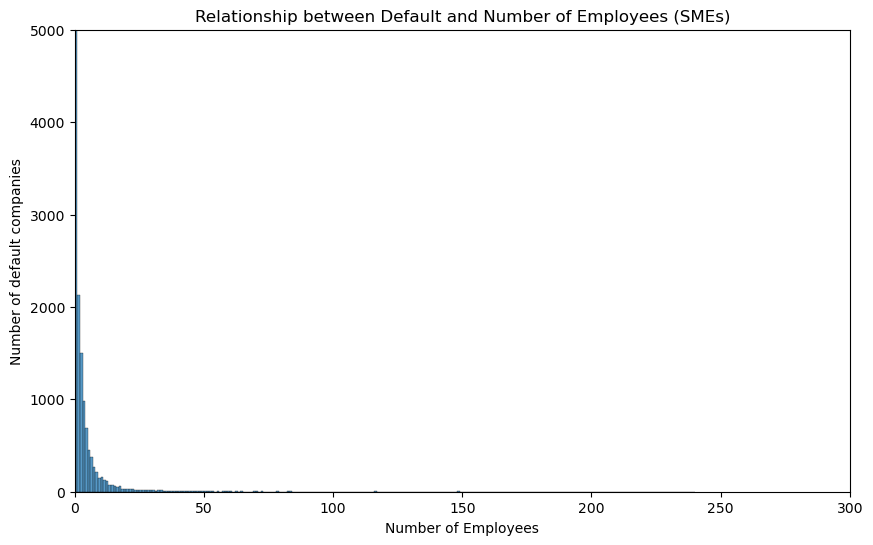

In [14]:
count_default(df=SMEs_2022_v2, x_variable='Dipendenti\nAnno - 1', x_label = 'Number of Employees')

[Text(0, 0.5, 'Number of companies')]

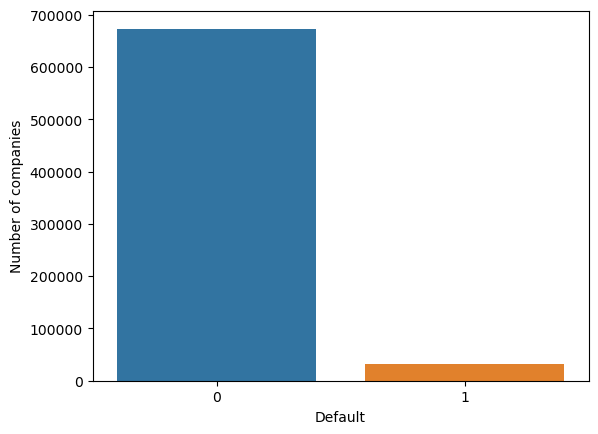

In [19]:
# Chart to show data unbalancedness

ax = sns.countplot(SMEs_2022_v2, x='Default')

ax.set(ylabel='Number of companies')

In [10]:
# Here we create a new dataframe shrinking the original one by keeping only 2021 variables,
# rename its columns and translate them in english

df = SMEs_2022_v2.loc[:, SMEs_2022_v2.columns.str.contains('Anno - 1')]

columns_names = df.columns.to_list()
renamed_columns = [s.split('\n')[0] for s in columns_names]

df.columns = renamed_columns

english_columns_names = ['Total Assets', 'Net Worth', 'Liquidity Ratio',
                'Current Ratio', 'Short-term Debt Ratio',
                'Long-term Debt Ratio',
                'Coverage Ratio of Fixed Assets (Equity)',
                'Debt Ratio',
                'Coverage Ratio of Fixed Assets (Financial)',
                'Payables to Banks over Sales (%)', 'Cost of Borrowed Money (%)',
                'Degree of Coverage of Interest Expenses',
                'Financial Charges over Sales (%)', 'Net Financial Position',
                'Debt/Equity', 'Debt/EBITDA',
                'Invested Capital Turnover (times)', 'Gross Working Capital Turnover (times)',
                'Operating Circulating Incidence (%)', 'EBITDA', 'EBITDA/Sales (%)',
                'Return on Total Assets (ROA) (%)',
                'Return on Total Invested Capital (ROI) (%)',
                'Return on Sales (ROS) (%)',
                'Return on Equity (ROE) (%)', 'Employees',
                'Revenue per Capita', 'Value Added per Capita',
                'Labor Cost per Employee', 'Employee Yield',
                'Net Working Capital', 'Gross Profit',
                'Treasury Margin', 'Structure Margin',
                'Operating Cash Flow']

df.columns = english_columns_names
df

,Total Assets,Net Worth,Liquidity Ratio,Current Ratio,Short-term Debt Ratio,Long-term Debt Ratio,Coverage Ratio of Fixed Assets (Equity),Debt Ratio,Coverage Ratio of Fixed Assets (Financial),Payables to Banks over Sales (%),...,Employees,Revenue per Capita,Value Added per Capita,Labor Cost per Employee,Employee Yield,Net Working Capital,Gross Profit,Treasury Margin,Structure Margin,Operating Cash Flow
0,1.784960e+07,10739962.0,2.45,2.45,1.00,0.00,0.03,1.66,10.91,0.00,...,19.0,NaN,483520.0,39270.0,NaN,9987058.0,30830465.0,5588599.0,9755730.0,6147720.0
1,3.659640e+07,1419462.0,0.96,0.96,1.00,0.00,0.00,25.78,NaN,0.01,...,2.0,NaN,114880.0,61750.0,NaN,-1374438.0,381573.0,-1396822.0,1418799.0,66803.0
2,4.131202e+06,4014416.0,2.36,2.36,1.00,0.00,0.00,1.03,1.03,0.00,...,6.0,30100.0,18710.0,15320.0,1.96,135844.0,170000.0,125563.0,125634.0,14980.0
3,2.839008e+07,1584734.0,1.02,1.02,1.00,0.00,0.00,17.91,1.48,0.00,...,1.0,NaN,217320.0,NaN,NaN,554805.0,1418104.0,-1913997.0,510691.0,96398.0
4,2.736108e+07,3968897.0,1.27,1.27,0.92,0.08,0.00,6.89,NaN,0.88,...,4.0,NaN,486630.0,78320.0,NaN,5892110.0,6009963.0,5024860.0,3967724.0,1166672.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705668,1.709332e+06,1180309.0,NaN,NaN,0.22,0.78,0.00,1.45,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,1594765.0,0.0,NaN,1180309.0,-6372.0
705669,9.608850e+05,-1131778.0,0.46,0.46,1.00,0.00,0.00,-0.85,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,-1131778.0,48000.0,NaN,NaN,243111.0
705670,1.503000e+04,-31934.0,1.16,1.16,0.34,0.66,0.00,-0.47,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,2066.0,0.0,NaN,NaN,0.0
705671,2.266300e+04,20587.0,0.01,0.01,1.00,0.00,1.10,1.10,0.91,NaN,...,0.0,NaN,NaN,NaN,NaN,-2054.0,0.0,NaN,-2054.0,-271.0


In [11]:
descriptive_statistics = df.loc[:,['Liquidity Ratio', 'Debt Ratio', 'Invested Capital Turnover (times)', 'EBITDA/Sales (%)',
'Return on Total Assets (ROA) (%)', 'Return on Total Invested Capital (ROI) (%)', 'Return on Sales (ROS) (%)',
'Return on Equity (ROE) (%)', 'Gross Profit']].describe()

In [12]:
descriptive_statistics

,Liquidity Ratio,Debt Ratio,Invested Capital Turnover (times),EBITDA/Sales (%),Return on Total Assets (ROA) (%),Return on Total Invested Capital (ROI) (%),Return on Sales (ROS) (%),Return on Equity (ROE) (%),Gross Profit
count,652074.00000,704951.000000,698113.000000,649997.000000,704969.000000,255078.000000,533818.000000,635336.000000,7.033580e+05
mean,1.76333,9.621600,0.907997,7.384160,4.187286,7.072052,5.054378,14.892313,8.224005e+05
std,1.70086,116.753275,0.884172,68.975526,33.814637,10.237126,11.763024,34.210095,2.555698e+06
min,0.00000,-1998.020000,0.000000,-999.850000,-997.530000,-29.990000,-50.000000,-150.000000,-6.287743e+07
25%,0.71000,1.450000,0.110000,3.060000,0.000000,0.990000,1.260000,0.440000,3.265600e+04
50%,1.25000,2.730000,0.760000,9.250000,3.490000,5.810000,4.720000,9.630000,1.626615e+05
75%,2.18000,6.250000,1.370000,23.070000,10.770000,13.550000,11.080000,29.540000,5.955735e+05
max,10.00000,9933.450000,5.000000,980.680000,997.410000,30.000000,30.000000,149.970000,2.377581e+08


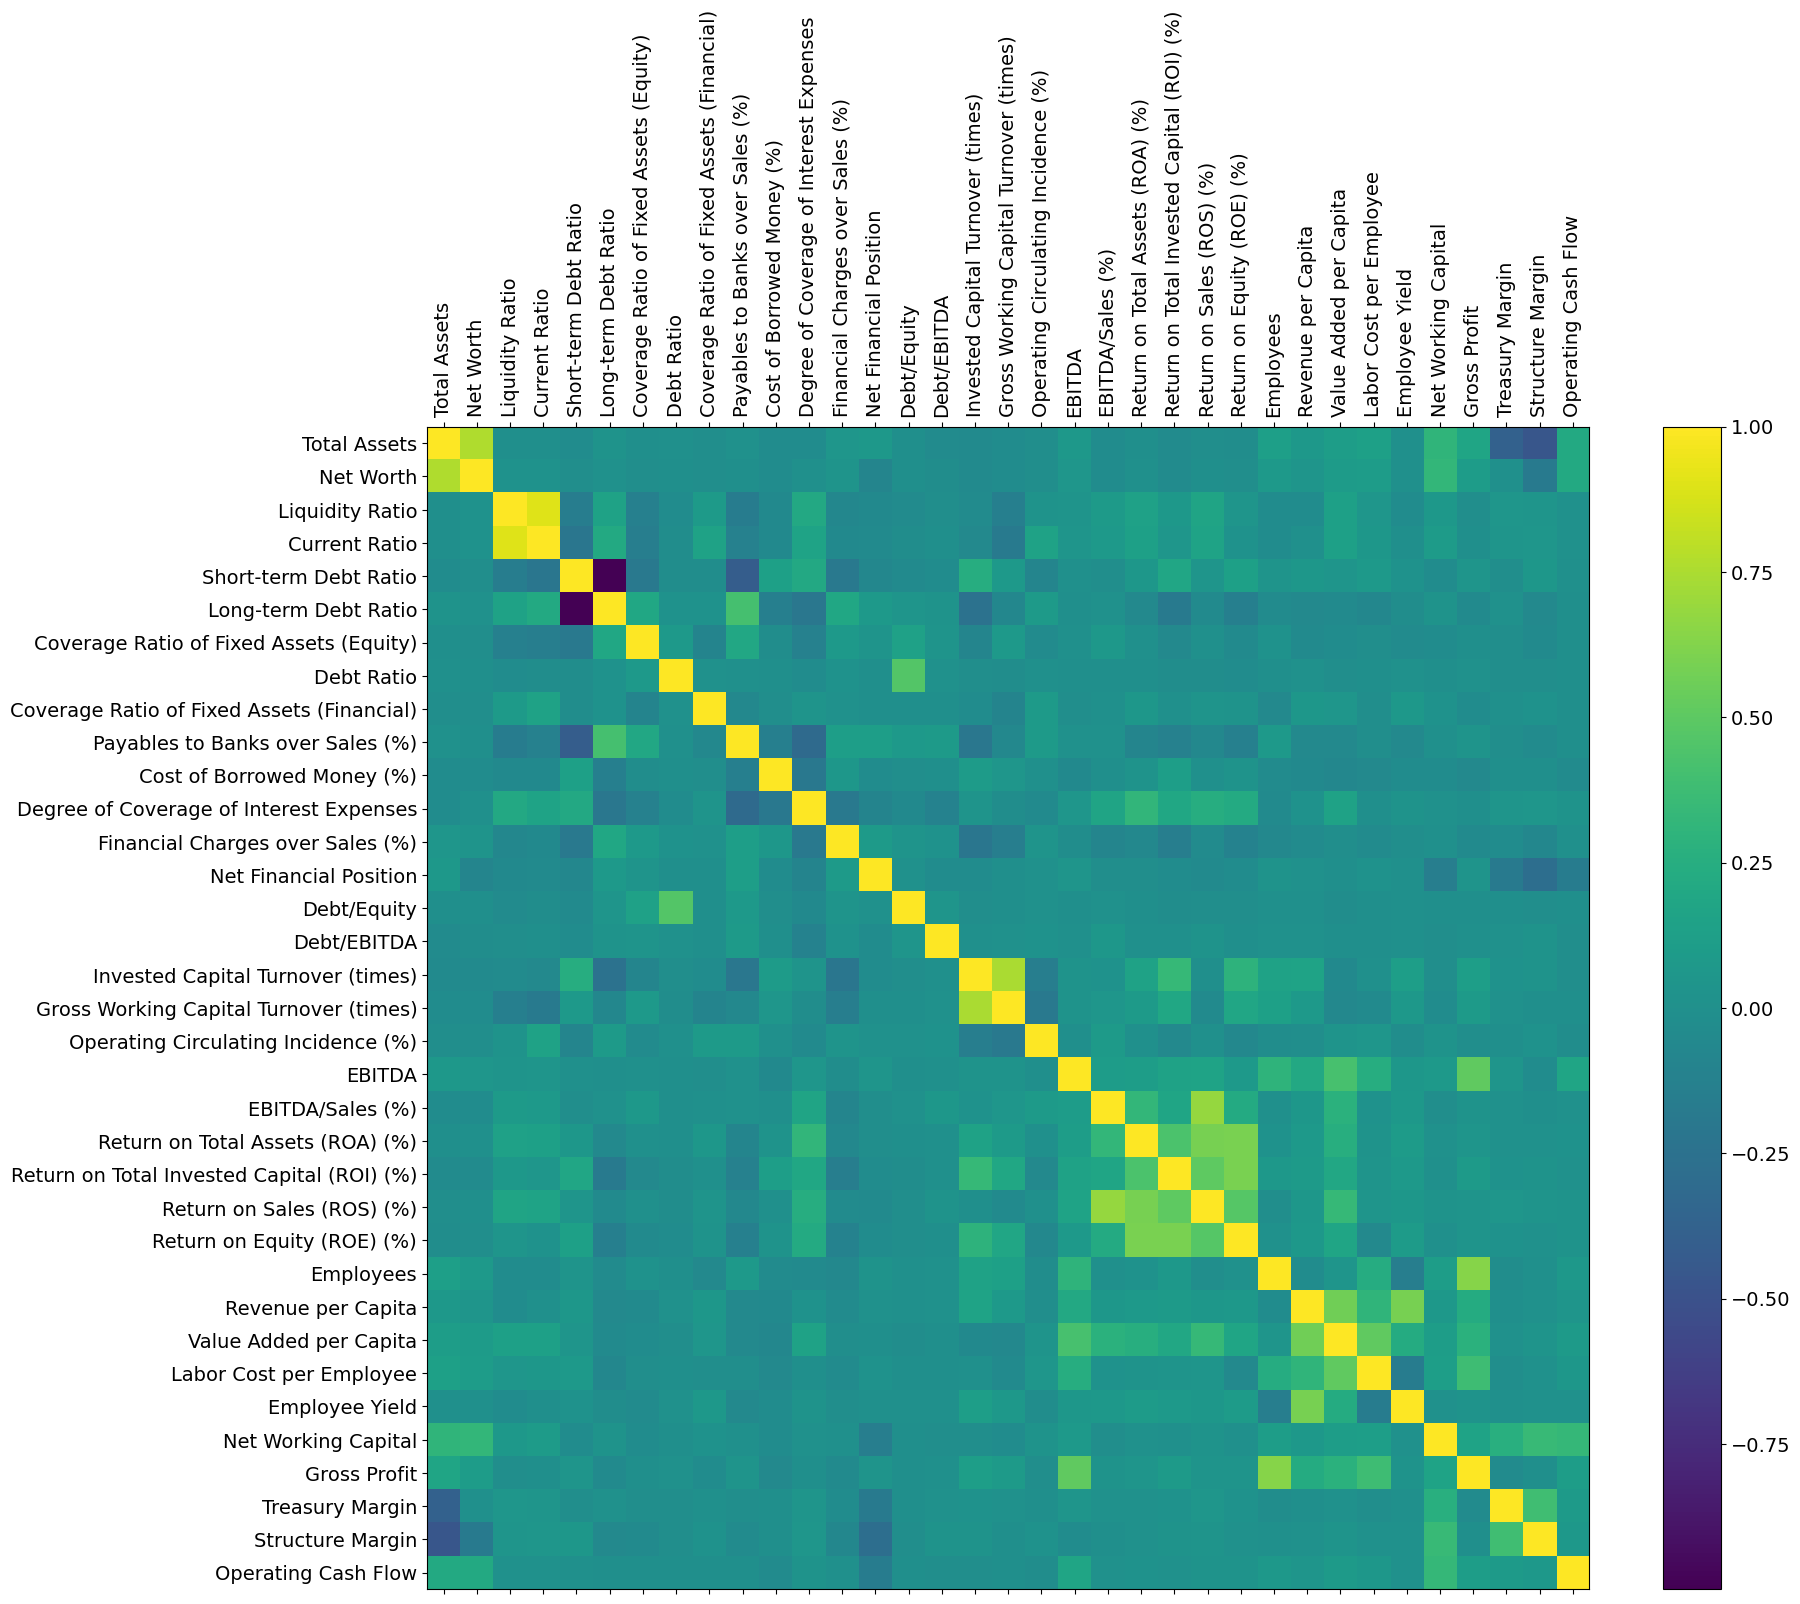

In [13]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(method='pearson'), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16)

plt.show()

## Train-Test split, Missing values and Outliers

In [6]:
SMEs_2022_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 +'/SMEs_2022_v2.csv'))

In [7]:
SMEs_2022_v2 = SMEs_2022_v2.drop(SMEs_2022_v2.columns[SMEs_2022_v2.columns.str.startswith('20')], axis=1)

SMEs_2022_v2 = SMEs_2022_v2.loc[:, ~SMEs_2022_v2.columns.str.contains('Ultimo')]

In [8]:
SMEs_2022_v2 = set_types_columns(SMEs_2022_v2, string_columns)

In [9]:
float_cols_SMEs = SMEs_2022_v2.select_dtypes(include=['float64']).columns.to_list()

In [10]:
# Train - Test split for SMEs

X_SMEs = SMEs_2022_v2[float_cols_SMEs]
X_SMEs.drop(['Default'], axis=1, inplace=True)
y_SMEs = SMEs_2022_v2.loc[:, SMEs_2022_v2.columns == 'Default']

X_train_SMEs, X_test_SMEs, y_train_SMEs, y_test_SMEs = train_test_split(X_SMEs, y_SMEs, test_size=0.3, random_state=0)

In [ ]:
X_train_SMEs_v2, y_train_SMEs_v2 = preprocessing_df(X=X_train_SMEs,
                                                    y=y_train_SMEs,
                                                    threshold_col=0.8,
                                                    threshold_row=0.5,
                                                    method_missings_interpolation='cubic',
                                                    method_outliers_identification='interquartile_range',
                                                    threshold_outliers=3,
                                                    method_outliers_transformation='winsorization')
X_train_SMEs_v2

,Costo denaro a prestito (%)\n%\nAnno - 4,Costo denaro a prestito (%)\n%\nAnno - 3,Costo denaro a prestito (%)\n%\nAnno - 2,Costo denaro a prestito (%)\n%\nAnno - 1,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 2,Debiti v/banche su fatt. (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 1,Incidenza circolante operativo (%)\n%\nAnno - 4,...,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1,Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1,No of companies in corporate group,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 1,Dipendenti\nAnno - 1,Società artigiana Encoded,PMI innovativa Encoded,Start-up innovativa Encoded,Operatore estero Encoded
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12570.0,28674.0,44818.0,3.0,143875.0,2.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9418.0,10242.0,21121.0,0.0,60056.0,9.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30133.0,33941.0,104057.0,0.0,625641.0,12.0,1.0,0.0,0.0,0.0
3,NaN,0.01,0.00,0.000000,15.57,6.90,5.69,0.00,7.02,NaN,...,27548.0,37506.0,132137.0,0.0,679487.0,6.0,0.0,0.0,0.0,0.0
4,4.57000,4.57,9.63,4.140000,4.65,5.19,20.64,60.75,6.45,38.56000,...,100000.0,140585.0,495638.0,3.0,1799730.0,13.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418641,35.17737,NaN,NaN,1.459352,13.45,NaN,13.79,0.00,NaN,20.01401,...,4267.0,6799.0,21988.0,0.0,161437.0,2.0,0.0,0.0,0.0,0.0
418642,11.30000,NaN,NaN,2.011069,NaN,NaN,NaN,0.79,NaN,19.51000,...,350194.0,484717.0,816738.0,5.0,1403410.0,13.0,0.0,0.0,0.0,0.0
418643,NaN,NaN,NaN,2.212726,NaN,NaN,NaN,0.00,NaN,10.93000,...,219864.0,287176.0,242155.0,0.0,968265.0,4.0,0.0,0.0,0.0,0.0
418644,NaN,NaN,NaN,1.985359,NaN,NaN,NaN,0.13,NaN,-3.86000,...,4003.0,4548.0,24320.0,2.0,154374.0,5.0,0.0,0.0,0.0,0.0


In [ ]:
X_test_SMEs_v2, y_test_SMEs_v2 = preprocessing_df(X=X_test_SMEs,
                                                  y=y_test_SMEs,
                                                  threshold_col=0.8,
                                                  threshold_row=0.5,
                                                  method_missings_interpolation='cubic',
                                                  method_outliers_identification='interquartile_range',
                                                  threshold_outliers=3,
                                                  method_outliers_transformation='winsorization')
X_test_SMEs_v2 = X_test_SMEs_v2[X_train_SMEs_v2.columns]
X_test_SMEs_v2

,Costo denaro a prestito (%)\n%\nAnno - 4,Costo denaro a prestito (%)\n%\nAnno - 3,Costo denaro a prestito (%)\n%\nAnno - 2,Costo denaro a prestito (%)\n%\nAnno - 1,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 2,Debiti v/banche su fatt. (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 1,Incidenza circolante operativo (%)\n%\nAnno - 4,...,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1,Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1,No of companies in corporate group,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 1,Dipendenti\nAnno - 1,Società artigiana Encoded,PMI innovativa Encoded,Start-up innovativa Encoded,Operatore estero Encoded
0,NaN,12.600000,2.490000,NaN,15.690000,4.110000,26.450000,0.000000,2.900000,-5.650000,...,83925.0,91493.0,492256.0,2.0,1532856.0,17.0,0.0,0.0,0.0,0.0
1,NaN,9.159511,4.209299,NaN,0.610000,1.370000,1.230000,0.000000,1.370000,28.630000,...,16072.0,16073.0,158662.0,0.0,321364.0,5.0,0.0,0.0,0.0,0.0
2,NaN,6.445224,4.690725,NaN,8.078392,9.917684,7.245490,24.805090,9.057237,24.682448,...,56745.0,66167.0,125818.0,0.0,1858824.0,13.0,0.0,0.0,0.0,0.0
3,3.140000,4.430000,4.290000,4.090000,24.350000,18.110000,22.000000,46.650000,15.990000,5.080000,...,1243137.0,1492757.0,3259226.0,0.0,11376564.0,28.0,0.0,0.0,0.0,0.0
4,-2.566109,3.086701,3.362844,-2.879844,37.564101,17.033940,27.439771,44.814423,14.670441,-10.999911,...,41393.0,42737.0,44368.0,3.0,220906.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179211,10.436106,-35.000336,1.739032,3.368629,6.317832,18.760000,4.854858,0.000000,-0.621806,4.790000,...,26025.0,26046.0,52686.0,2.0,370082.0,16.0,0.0,0.0,0.0,0.0
179212,9.623434,-35.797086,0.670000,1.810000,15.090000,5.920000,8.950000,0.000000,8.470000,23.920000,...,55349.0,77422.0,372611.0,0.0,707496.0,1.0,0.0,0.0,0.0,0.0
179213,7.566068,-24.162764,0.550484,1.307971,18.131691,9.641048,7.654683,13.137984,20.621945,40.875558,...,7819.0,11226.0,15048.0,0.0,447067.0,8.0,0.0,0.0,0.0,0.0
179214,4.040000,3.740000,1.830000,2.400000,13.280000,18.950000,3.280000,22.000000,22.520000,41.330000,...,366943.0,526321.0,510019.0,3.0,3687136.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# We assing the mean of the column to the remaining NaNs

for col in X_train_SMEs_v2.columns:
    X_train_SMEs_v2[col].fillna(X_train_SMEs_v2[col].mean(), inplace=True)

for col in X_test_SMEs_v2.columns:
    X_test_SMEs_v2[col].fillna(X_test_SMEs_v2[col].mean(), inplace=True)

In [ ]:
# X_train_SMEs_v2.to_csv(path_v2 + '/X_train_SMEs_v2.csv', index=False)
# y_train_SMEs_v2.to_csv(path_v2 + '/y_train_SMEs_v2.csv', index=False)
# X_test_SMEs_v2.to_csv(path_v2 + '/X_test_SMEs_v2.csv', index=False)
# y_test_SMEs_v2.to_csv(path_v2 + '/y_test_SMEs_v2.csv', index=False)

# Oversampling (SMOTE)

In [6]:
X_train_SMEs_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/X_train_SMEs_v2.csv'))
y_train_SMEs_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/y_train_SMEs_v2.csv'))
X_test_SMEs_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/X_test_SMEs_v2.csv'))
y_test_SMEs_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/y_test_SMEs_v2.csv'))

In [7]:
os = SMOTE()

# Oversampling the training data

os_X_train_SMEs, os_y_train_SMEs = os.fit_resample(X_train_SMEs_v2, y_train_SMEs_v2)

os_X_train_SMEs = pd.DataFrame(data=os_X_train_SMEs, columns=X_train_SMEs_v2.columns)
os_y_train_SMEs = pd.DataFrame(data=os_y_train_SMEs, columns=['Default'])

# Check the numbers

print("The length of oversampled data is: ",
      len(os_X_train_SMEs))
print("Number of non-default companies in oversampled data: ",
      len(os_y_train_SMEs[os_y_train_SMEs['Default']==0]))
print("Proportion of non-default companies data in oversampled data is ",
      len(os_y_train_SMEs[os_y_train_SMEs['Default']==0])/len(os_X_train_SMEs))
print("\n")
print("Number of default companies in oversampled data: ",
      len(os_y_train_SMEs[os_y_train_SMEs['Default']==1]))
print("Proportion of default companies data in oversampled data is ",
      len(os_y_train_SMEs[os_y_train_SMEs['Default']==1])/len(os_X_train_SMEs))

The length of oversampled data is:  798320
Number of non-default companies in oversampled data:  399160
Proportion of non-default companies data in oversampled data is  0.5


Number of default companies in oversampled data:  399160
Proportion of default companies data in oversampled data is  0.5


In [8]:
X_test_SMEs_v2.shape, y_test_SMEs_v2.shape

((179216, 146), (179216, 1))

In [9]:
X_train_SMEs_v2.shape, y_train_SMEs_v2.shape

((418646, 146), (418646, 1))

In [10]:
os_X_train_SMEs.shape, os_y_train_SMEs.shape

((798320, 146), (798320, 1))

# Pipeline function

In [15]:
def build_and_evaluate_pipeline(X_train, y_train, X_test, y_test, model, scaling=True, selector_k=None,
                                model_param_grid=None, scoring='accuracy', cv=5):

    # 1: Define the steps

    if scaling == True:
        steps = [('scaler', StandardScaler())]
    else:
        steps = []

    if selector_k is not None:
        steps.append(('subset_selector', SelectKBest(score_func=f_classif, k=selector_k)))

    steps.append(('model', model))

    # 2: Create the pipeline
    pipeline = Pipeline(steps)

    # 3: GridSearchCV for hyperparameters tuning
    if model_param_grid is not None:
        grid_search = GridSearchCV(pipeline, {'model__' + k: v for k, v in model_param_grid.items()}, scoring=scoring, cv=cv)
        grid_search.fit(X_train, y_train)

        # 4: Get the best pipeline and its parameters
        best_pipeline = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # 5: Use the best pipeline to make predictions
        predictions = best_pipeline.predict(X_test)

        model_used = best_pipeline

    else: # If no hyperparameter tuning is done
        
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)

        model_used = pipeline

    accuracy = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    return accuracy, cm, model_used

# Logistic Regression

In [17]:
# Dictionary of possible parameters to be passed to the GridSearch

# model_param_grid_logistic_regression = {"C": np.logspace(-3, 3, 7), "penalty": ["l1", "l2"]}

### SMEs

In [18]:
accuracy_SMEs_logistic_regression_os, cm_SMEs_logistic_regression_os, model_SMEs_logistic_regression_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=LogisticRegression(),
    scaling=True,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [19]:
accuracy_SMEs_logistic_regression_os

0.7747745736987769

In [20]:
cm_SMEs_logistic_regression_os

array([[132264,  38591],
       [  1773,   6588]], dtype=int64)

In [21]:
model_SMEs_logistic_regression_os

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

##### With subset selection:

In [22]:
accuracy_SMEs_logistic_regression_os_ss, cm_SMEs_logistic_regression_os_ss, model_SMEs_logistic_regression_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=LogisticRegression(),
    scaling=True,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [23]:
accuracy_SMEs_logistic_regression_os_ss

0.7713931791804303

In [24]:
cm_SMEs_logistic_regression_os_ss

array([[131670,  39185],
       [  1785,   6576]], dtype=int64)

In [25]:
model_SMEs_logistic_regression_os_ss

Pipeline(steps=[('scaler', StandardScaler()),
                ('subset_selector', SelectKBest(k=70)),
                ('model', LogisticRegression())])

# Linear Discriminant Analysis

In [34]:
# model_param_grid_lda = {'solver': ['svd', 'lsqr', 'eigen'],
#                        'shrinkage':['auto', None]}

### SMEs

In [35]:
accuracy_SMEs_lda_os, cm_SMEs_lda_os, model_SMEs_lda_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=LinearDiscriminantAnalysis(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [36]:
accuracy_SMEs_lda_os

0.7687092670297295

In [37]:
cm_SMEs_lda_os

array([[131276,  39579],
       [  1872,   6489]], dtype=int64)

In [38]:
model_SMEs_lda_os

Pipeline(steps=[('model', LinearDiscriminantAnalysis())])

##### With subset selection:

In [39]:
accuracy_SMEs_lda_os_ss, cm_SMEs_lda_os_ss, model_SMEs_lda_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=LinearDiscriminantAnalysis(),
    scaling=False,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [40]:
accuracy_SMEs_lda_os_ss

0.7649372823855013

In [41]:
cm_SMEs_lda_os_ss

array([[130584,  40271],
       [  1856,   6505]], dtype=int64)

In [42]:
model_SMEs_lda_os_ss

Pipeline(steps=[('subset_selector', SelectKBest(k=70)),
                ('model', LinearDiscriminantAnalysis())])

# KNN

In [51]:
# Dictionary of possible parameters to be passed to the GridSearch

# k_range = list(range(4,7))
# model_param_grid_knn = dict(n_neighbors=k_range)

### SMEs

In [52]:
accuracy_SMEs_knn_os, cm_SMEs_knn_os, model_SMEs_knn_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=KNeighborsClassifier(),
    scaling=True,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [53]:
accuracy_SMEs_knn_os

0.8074000089277743

In [54]:
cm_SMEs_knn_os

array([[139744,  31111],
       [  3406,   4955]], dtype=int64)

In [55]:
model_SMEs_knn_os

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier())])

##### With subset selection:

In [56]:
accuracy_SMEs_knn_os_ss, cm_SMEs_knn_os_ss, model_SMEs_knn_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=KNeighborsClassifier(),
    scaling=True,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [57]:
accuracy_SMEs_knn_os_ss

0.8264719667886796

In [58]:
cm_SMEs_knn_os_ss

array([[143158,  27697],
       [  3402,   4959]], dtype=int64)

In [59]:
model_SMEs_knn_os_ss

Pipeline(steps=[('scaler', StandardScaler()),
                ('subset_selector', SelectKBest(k=70)),
                ('model', KNeighborsClassifier())])

# Decision tree

In [69]:
# model_param_grid_decision_tree = {
#     'max_features': ['auto', 'sqrt', 'log2', None],
#     'ccp_alpha': [0.0, 0.1, .01, .001],
#     'max_depth' : [5, 6, 7, 8, 9],
#     'criterion' :['gini', 'entropy', 'log_loss']
# }

### SMEs

In [70]:
accuracy_SMEs_dt_os, cm_SMEs_dt_os, model_SMEs_dt_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=DecisionTreeClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [71]:
accuracy_SMEs_dt_os

0.8986809213463084

In [72]:
cm_SMEs_dt_os

array([[157495,  13360],
       [  4798,   3563]], dtype=int64)

In [73]:
model_SMEs_dt_os

Pipeline(steps=[('model', DecisionTreeClassifier())])

##### With subset selection:

In [74]:
accuracy_SMEs_dt_os_ss, cm_SMEs_dt_os_ss, model_SMEs_dt_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=DecisionTreeClassifier(),
    scaling=False,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [75]:
accuracy_SMEs_dt_os_ss

0.8838552361396304

In [76]:
cm_SMEs_dt_os_ss

array([[154487,  16368],
       [  4447,   3914]], dtype=int64)

In [77]:
model_SMEs_dt_os_ss

Pipeline(steps=[('subset_selector', SelectKBest(k=70)),
                ('model', DecisionTreeClassifier())])

# Random forest

In [86]:
# model_param_grid_rf = {
#     "n_estimators":[100, 200, 300],
#     "max_depth":[10, 20, 30, None],
#     "bootstrap":[True, False],
#     "min_samples_split":[2, 5, 10],
#     "min_samples_leaf":[1, 2, 4],
# }

### SMEs

In [87]:
accuracy_SMEs_rf_os, cm_SMEs_rf_os, model_SMEs_rf_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=RandomForestClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [88]:
accuracy_SMEs_rf_os

0.9458530488349255

In [89]:
cm_SMEs_rf_os

array([[165499,   5356],
       [  4348,   4013]], dtype=int64)

In [90]:
model_SMEs_rf_os

Pipeline(steps=[('model', RandomForestClassifier())])

In [91]:
feature_names_SMEs_rf = [col for col in os_X_train_SMEs.columns]
importances_SMEs_rf = model_SMEs_rf_os['model'].feature_importances_

forest_importances_SMEs_rf = pd.Series(importances_SMEs_rf, index=feature_names_SMEs_rf)

forest_importances_SMEs_rf.sort_values(ascending=False).to_dict()

{'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.0516580808770224,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.037544989290251844,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.03736047573471227,
 'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1': 0.0358050696998108,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.035501112905548714,
 'Dipendenti\nAnno - 1': 0.034223742427333025,
 'No of companies in corporate group': 0.0315997511093668,
 'Rapporto di indebitamento\nAnno - 1': 0.030511907452089555,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 2': 0.02576621032612181,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2': 0.01955181149082383,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 1': 0.01915854309297689,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.019089863169439992,
 'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 2': 0.018798903758775912,
 'Indice di copertu

##### With subset selection:

In [92]:
accuracy_SMEs_rf_os_ss, cm_SMEs_rf_os_ss, model_SMEs_rf_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=RandomForestClassifier(),
    scaling=False,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [93]:
accuracy_SMEs_rf_os_ss

0.9388614855816445

In [94]:
cm_SMEs_rf_os_ss

array([[164017,   6838],
       [  4119,   4242]], dtype=int64)

In [95]:
model_SMEs_rf_os_ss

Pipeline(steps=[('subset_selector', SelectKBest(k=70)),
                ('model', RandomForestClassifier())])

In [96]:
model_SMEs_rf_os_ss.named_steps

{'subset_selector': SelectKBest(k=70), 'model': RandomForestClassifier()}

In [97]:
feature_names_SMEs_rf_ss = [col for col in model_SMEs_rf_os_ss['subset_selector'].get_feature_names_out()]
importances_SMEs_rf_ss = model_SMEs_rf_os_ss['model'].feature_importances_

forest_importances_SMEs_rf_ss = pd.Series(importances_SMEs_rf_ss, index=feature_names_SMEs_rf_ss)

forest_importances_SMEs_rf_ss.sort_values(ascending=False).to_dict()

{'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.06728349956149808,
 'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.06450935423199394,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.05506203601124189,
 'Dipendenti\nAnno - 1': 0.037215523591253456,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.03198704424965041,
 'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1': 0.030017738602416365,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 1': 0.029833570108584864,
 'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 2': 0.02825830079979555,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.027470474483801924,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 1': 0.02271177091415907,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 2': 0.02104862887867048,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2': 0.020443980097021645,
 'Dipendenti\nAnno - 2': 0.019603262911142

# Gradient Boosting

In [108]:
# model_param_grid_gradient_boosting = {
#     'loss':['log_loss', 'deviance', 'exponential'],
#     'n_estimators': [10, 50, 100],
#     'learning_rate': np.arange(0.0, 0.6)
# }

### SMEs

In [109]:
accuracy_SMEs_gb_os, cm_SMEs_gb_os, model_SMEs_gb_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=GradientBoostingClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [110]:
accuracy_SMEs_gb_os

0.9214021069547362

In [111]:
cm_SMEs_gb_os

array([[160429,  10426],
       [  3660,   4701]], dtype=int64)

In [112]:
model_SMEs_gb_os

Pipeline(steps=[('model', GradientBoostingClassifier())])

In [113]:
feature_names_SMEs_gb = [col for col in os_X_train_SMEs.columns]
importances_SMEs_gb = model_SMEs_gb_os['model'].feature_importances_

forest_importances_SMEs_gb = pd.Series(importances_SMEs_gb, index=feature_names_SMEs_gb)

forest_importances_SMEs_gb.sort_values(ascending=False).to_dict()

{'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.32028926381228395,
 'No of companies in corporate group': 0.1828195572311149,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.07020679841490442,
 'Dipendenti\nAnno - 1': 0.059351760118921404,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.057933288673549854,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.053613190322150735,
 'Capitale sociale (EUR)': 0.03758070220502492,
 'Rapporto di indebitamento\nAnno - 1': 0.030456105196418337,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.022483380878389848,
 'Dipendenti\nAnno - 4': 0.015285831827900151,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2': 0.014601286576976366,
 'Indice di copertura delle immob. (finanziario)\n%\nAnno - 1': 0.013241106335377693,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 1': 0.009844986416841109,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 1': 0.00958742471

##### With subset selection:

In [114]:
accuracy_SMEs_gb_os_ss, cm_SMEs_gb_os_ss, model_SMEs_gb_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=GradientBoostingClassifier(),
    scaling=False,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [115]:
accuracy_SMEs_gb_os_ss

0.8704970538344791

In [116]:
cm_SMEs_gb_os_ss

array([[150266,  20589],
       [  2620,   5741]], dtype=int64)

In [117]:
model_SMEs_gb_os_ss

Pipeline(steps=[('subset_selector', SelectKBest(k=70)),
                ('model', GradientBoostingClassifier())])

In [118]:
feature_names_SMEs_gb_ss = [col for col in model_SMEs_gb_os_ss['subset_selector'].get_feature_names_out()]
importances_SMEs_gb_ss = model_SMEs_gb_os_ss['model'].feature_importances_

forest_importances_SMEs_gb_ss = pd.Series(importances_SMEs_gb_ss, index=feature_names_SMEs_gb_ss)

forest_importances_SMEs_gb_ss.sort_values(ascending=False).to_dict()

{'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.37082902529436435,
 'Dipendenti\nAnno - 1': 0.11639602989370412,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.09428718900893118,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.08783883604754629,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.041474474318925286,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.02100959141311679,
 'Indice di indebitam. a breve\n%\nAnno - 2': 0.019170918797044256,
 'Società artigiana Encoded': 0.018363413984543355,
 'Dipendenti\nAnno - 4': 0.018049355055656476,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2': 0.016344148664130413,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 1': 0.015784791411905058,
 'Dipendenti\nAnno - 3': 0.01504134877251445,
 'Oneri finanz. su fatt. (%)\n%\nAnno - 4': 0.014389553155133617,
 'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1': 0.013501056128193986,
 'Rot

# Models comparison and evaluation

In [30]:
Models = ['Logistic Regression', 'LDA', 'KNN', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
Accuracy_SMEs = [0.7747745736987769, 0.7687092670297295, 0.8074000089277743, 0.8986809213463084, 0.9458530488349255, 0.9214021069547362]
Accuracy_SMEs_ss = [0.7713931791804303, 0.7649372823855013, 0.8264719667886796, 0.8838552361396304, 0.9388614855816445, 0.8704970538344791]

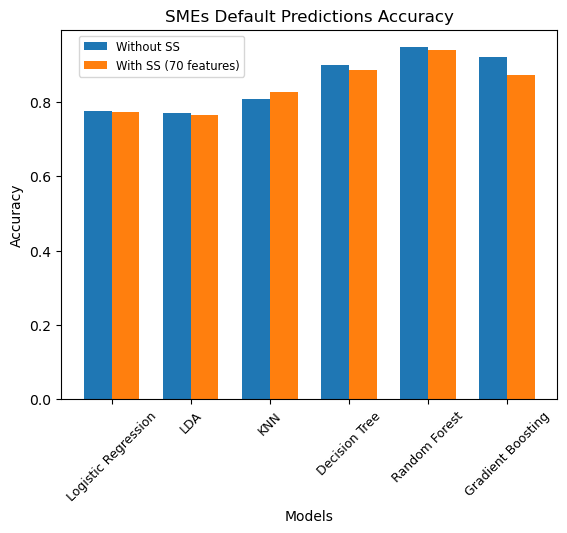

In [31]:
fig, ax = plt.subplots()

x = np.arange(0, len(Models))
width = 0.35

ax.bar(x-width/2, Accuracy_SMEs, width, label='Without SS')
ax.bar(x+width/2, Accuracy_SMEs_ss, width, label='With SS (70 features)')

plt.xticks(x, Models, rotation=45)

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')

plt.tick_params(axis='x', labelsize=9)
plt.tick_params(axis='y', labelsize=10)

ax.set_title('SMEs Default Predictions Accuracy')

fig.legend(bbox_to_anchor=(0.42,0.88), fontsize='small')
plt.show()

In [17]:
best_features_SMEs_rf = {
    'Gross Profit': 0.0516580808770224,
    'Operating Cash Flow': 0.037544989290251844,
    'EBITDA': 0.03736047573471227,
    'Return on Assets (ROA) (%)': 0.0358050696998108,
    'Net Worth': 0.035501112905548714,
    'Employees': 0.034223742427333025,
    'Num. of companies in corporate group': 0.0315997511093668,
    'Debt Ratio': 0.030511907452089555,
    'EBITDA (2020)': 0.02576621032612181,
    'Operating Cash Flow (2020)': 0.01955181149082383,
    'Gross Working Capital Turnover (times)': 0.01915854309297689,
    'EBITDA/Sales (%)': 0.019089863169439992,
    'Gross Profit 2020)': 0.018798903758775912,
    'Coverage Ratio of Fixed Assets (Equity)': 0.015197204595353746
}



best_features_SMEs_gb = {
    'Gross Profit': 0.32028926381228395,
    'Num. of companies in corporate group': 0.1828195572311149,
    'Operating Cash Flow': 0.07020679841490442,
    'Employees': 0.059351760118921404,
    'Net Worth': 0.057933288673549854,
    'EBITDA': 0.053613190322150735,
    'Social Capital': 0.03758070220502492,
    'Debt Ratio': 0.030456105196418337,
    'EBITDA/Sales (%)': 0.022483380878389848,
    'Employees (2018)': 0.015285831827900151,
    'Operating Cash Flow (2020)': 0.014601286576976366,
    'Coverage Ratio of Fixed Assets (Financial)': 0.013241106335377693,
    'Coverage Ratio of Fixed Assets (Equity)': 0.009844986416841109,
    'Gross Working Capital Turnover (times)': 0.009587424714290312
}

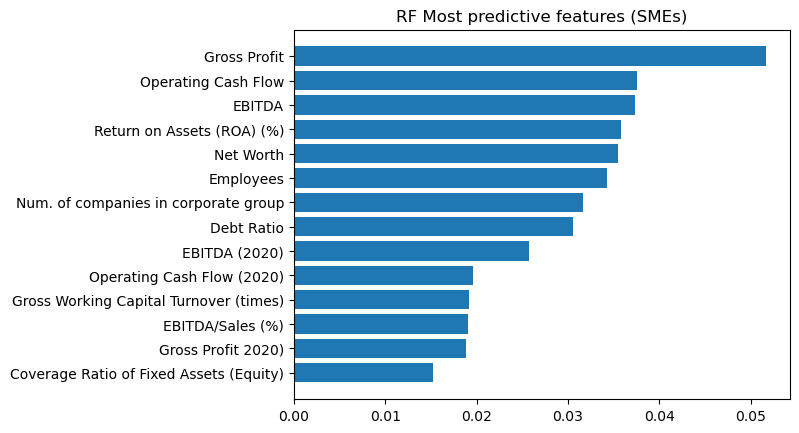

In [18]:
fig, ax = plt.subplots()

ax.barh(list(best_features_SMEs_rf.keys())[::-1],
       list(best_features_SMEs_rf.values())[::-1])
ax.set_title('RF Most predictive features (SMEs)')
plt.show()

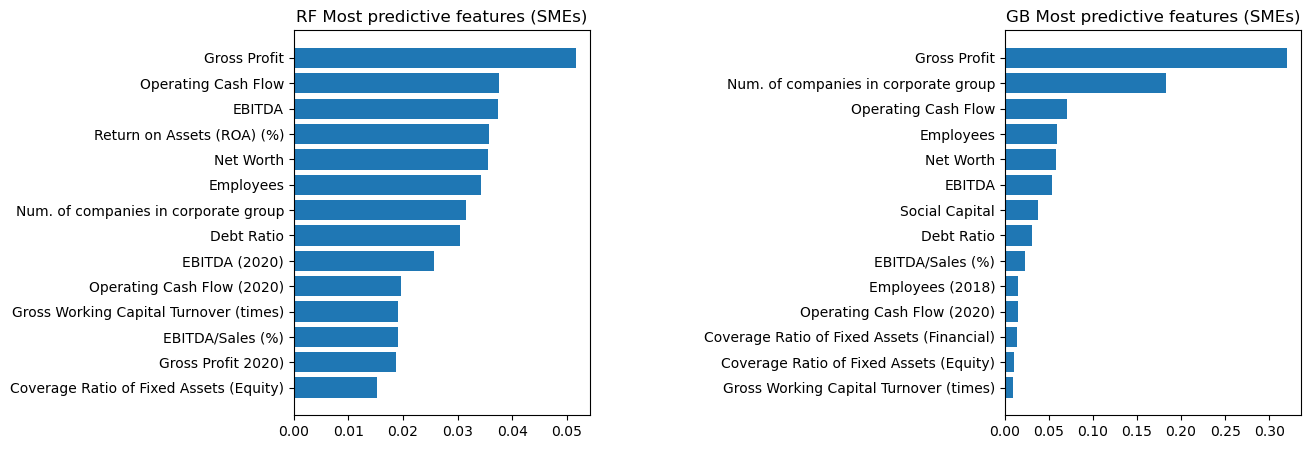

In [19]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=False, figsize=(13,5))
gs = gridspec.GridSpec(ncols=3, nrows=1)

ax1 = fig.add_subplot(gs[0,0])
ax2= fig.add_subplot(gs[0,2])

x = np.arange(0, 5)
width = 0.35

ax1.barh(list(best_features_SMEs_rf.keys())[::-1],
       list(best_features_SMEs_rf.values())[::-1])
ax1.set_title('RF Most predictive features (SMEs)')

ax2.barh(list(best_features_SMEs_gb.keys())[::-1],
       list(best_features_SMEs_gb.values())[::-1])
ax2.set_title('GB Most predictive features (SMEs)')


plt.show()

# Istat data

## Dataset cration

In [24]:
istat_data = pd.read_csv(path_tesi_folder +'/ISTAT/istat_data.csv')

In [ ]:
SMEs_2022_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/SMEs_2022_v2.csv'))

In [ ]:
SMEs_2022_v2 = SMEs_2022_v2.drop(SMEs_2022_v2.columns[SMEs_2022_v2.columns.str.startswith('20')], axis=1)

SMEs_2022_v2 = SMEs_2022_v2.loc[:, ~SMEs_2022_v2.columns.str.contains('Ultimo')]

In [ ]:
SMEs_2022_v2 = set_types_columns(SMEs_2022_v2, string_columns)

In [ ]:
float_cols_SMEs = SMEs_2022_v2.select_dtypes(include=['float64']).columns.to_list()

In [ ]:
istat_data

,ITTER107,Territorio,TIPO_DATO29,Variabile,ATECO_2007,Ateco 2007,TIME,Seleziona periodo,Value,Flag Codes,Flags
0,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),2018,2018,0.0,NaN,NaN
1,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),2019,2019,0.0,NaN,NaN
2,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),2020,2020,0.0,NaN,NaN
3,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),2021,2021,0.0,NaN,NaN
4,IT,Italia,11110,imprese,22,articoli in gomma e materie plastiche,2018,2018,9522.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3691,IT,Italia,12150,valore aggiunto al costo dei fattori (migliaia...,77,attività di noleggio e leasing operativo,2021,2021,8683272.0,NaN,NaN
3692,IT,Italia,16150,ore lavorate dai dipendenti (migliaia),77,attività di noleggio e leasing operativo,2018,2018,60623.0,NaN,NaN
3693,IT,Italia,16150,ore lavorate dai dipendenti (migliaia),77,attività di noleggio e leasing operativo,2019,2019,62288.0,NaN,NaN
3694,IT,Italia,16150,ore lavorate dai dipendenti (migliaia),77,attività di noleggio e leasing operativo,2020,2020,50584.0,NaN,NaN


In [ ]:
istat_data_pivot = istat_data.pivot_table(values='Value', index=['ATECO_2007'],
                       columns=['TIME', 'Variabile'], aggfunc="sum")

In [ ]:
istat_data_pivot

TIME                                                2018  \
Variabile  acquisto di beni e servizi (migliaia di euro)   
ATECO_2007                                                 
5                                                    0.0   
6                                              3728559.0   
7                                                   63.0   
8                                              1772722.0   
9                                               269769.0   
...                                                  ...   
91                                              274511.0   
92                                            10527751.0   
93                                             5558798.0   
95                                             1550439.0   
96                                             7375798.0   

TIME                                               \
Variabile  costi del personale (migliaia di euro)   
ATECO_2007                                          
5                                             0.0   
6                                        202948.0   
7                                            81.0   
8                                        544692.0   
9                                        130224.0   
...                                           ...   
91                                       289449.0   
92                                      1136726.0   
93                                      2950245.0   
95                                       467004.0   
96                                      4382294.0   

TIME                                               \
Variabile  fatturato (migliaia di euro)   imprese   
ATECO_2007                                          
5                                   0.0       0.0   
6                             5709248.0       9.0   
7                                  31.0       3.0   
8                             2741343.0    1793.0   
9                              398903.0      37.0   
...                                 ...       ...   
91                             625643.0     989.0   
92                           15097186.0    9265.0   
93                            7475398.0   30924.0   
95                            2570933.0   25108.0   
96                           15530513.0  188745.0   

TIME                                                                \
Variabile  investimenti lordi in beni materiali (migliaia di euro)   
ATECO_2007                                                           
5                                                         0.0        
6                                                    941674.0        
7                                                        11.0        
8                                                    153811.0        
9                                                     33347.0        
...                                                       ...        
91                                                    19019.0        
92                                                   276316.0        
93                                                   432934.0        
95                                                    54142.0        
96                                                   945398.0        

TIME                                                                         \
Variabile  lavoratori dipendenti margine operativo lordo (migliaia di euro)   
ATECO_2007                                                                    
5                            0.0                                        0.0   
6                         2287.0                                  1370403.0   
7                            2.0                                       14.0   
8                        12251.0                                   464265.0   
9                         1526.0                                     2547.0   
...                          ...                            

In [ ]:
l = []
for col in istat_data_pivot.columns:
    l.append(str(col[0]) + '_' + col[1])

istat_data_pivot.columns = l

In [ ]:
istat_data_pivot.index = istat_data_pivot.index.astype(str)
istat_data_pivot

,2018_acquisto di beni e servizi (migliaia di euro),2018_costi del personale (migliaia di euro),2018_fatturato (migliaia di euro),2018_imprese,2018_investimenti lordi in beni materiali (migliaia di euro),2018_lavoratori dipendenti,2018_margine operativo lordo (migliaia di euro),2018_occupati,2018_ore lavorate dai dipendenti (migliaia),2018_salari e stipendi (migliaia di euro),...,2021_fatturato (migliaia di euro),2021_imprese,2021_investimenti lordi in beni materiali (migliaia di euro),2021_lavoratori dipendenti,2021_margine operativo lordo (migliaia di euro),2021_occupati,2021_ore lavorate dai dipendenti (migliaia),2021_salari e stipendi (migliaia di euro),2021_valore aggiunto al costo dei fattori (migliaia di euro),2021_valore della produzione (migliaia di euro)
ATECO_2007,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3728559.0,202948.0,5709248.0,9.0,941674.0,2287.0,1370403.0,2287.0,3804.0,144501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,63.0,81.0,31.0,3.0,11.0,2.0,14.0,2.0,3.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1772722.0,544692.0,2741343.0,1793.0,153811.0,12251.0,464265.0,13890.0,20332.0,373271.0,...,3041148.0,1633.0,164826.0,12203.0,544373.0,13575.0,20370.0,389689.0,1111311.0,3155170.0
9,269769.0,130224.0,398903.0,37.0,33347.0,1526.0,2547.0,1537.0,2689.0,92171.0,...,490893.0,30.0,13064.0,1286.0,138229.0,1298.0,2081.0,80356.0,247585.0,512175.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,274511.0,289449.0,625643.0,989.0,19019.0,10844.0,64947.0,11537.0,14422.0,211995.0,...,527440.0,1125.0,9494.0,11044.0,71450.0,11836.0,13913.0,195491.0,337578.0,573603.0
92,10527751.0,1136726.0,15097186.0,9265.0,276316.0,31768.0,2113070.0,42818.0,45803.0,831483.0,...,14974691.0,7936.0,152335.0,28278.0,1933362.0,37223.0,28527.0,573942.0,2750179.0,15171334.0
93,5558798.0,2950245.0,7475398.0,30924.0,432934.0,61196.0,1716488.0,91858.0,76779.0,2434448.0,...,5160297.0,29529.0,943201.0,53981.0,424377.0,80717.0,61682.0,2675143.0,3633897.0,8728727.0


In [ ]:
anni = ['2021', '2020', '2019']
istat_data_pivot_v2 = istat_data_pivot.copy()

for year in anni:
    for col in istat_data_pivot.columns:
        if col.startswith(year):
            end_col = col.replace(year + '_', "")
            year_minus_one = str(int(year) - 1)
            year_variation = year_minus_one + '_' + year

            previous_data = istat_data_pivot_v2[year_minus_one + '_' + end_col]
            current_data = istat_data_pivot_v2[col]
            istat_data_pivot_v2[year_variation + '_' + end_col] = (current_data - previous_data) / previous_data

istat_data_pivot_v2.drop(istat_data_pivot.columns, axis=1, inplace=True)
istat_data_pivot_v2

,2020_2021_acquisto di beni e servizi (migliaia di euro),2020_2021_costi del personale (migliaia di euro),2020_2021_fatturato (migliaia di euro),2020_2021_imprese,2020_2021_investimenti lordi in beni materiali (migliaia di euro),2020_2021_lavoratori dipendenti,2020_2021_margine operativo lordo (migliaia di euro),2020_2021_occupati,2020_2021_ore lavorate dai dipendenti (migliaia),2020_2021_salari e stipendi (migliaia di euro),...,2018_2019_fatturato (migliaia di euro),2018_2019_imprese,2018_2019_investimenti lordi in beni materiali (migliaia di euro),2018_2019_lavoratori dipendenti,2018_2019_margine operativo lordo (migliaia di euro),2018_2019_occupati,2018_2019_ore lavorate dai dipendenti (migliaia),2018_2019_salari e stipendi (migliaia di euro),2018_2019_valore aggiunto al costo dei fattori (migliaia di euro),2018_2019_valore della produzione (migliaia di euro)
ATECO_2007,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.152212,0.222222,-0.138528,-0.042851,-0.203129,-0.042851,-0.020768,0.035232,-0.171736,-0.149615
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.064516,0.000000,15.363636,0.000000,0.357143,0.000000,0.000000,0.352941,0.210526,0.263158
8,0.205985,0.111854,0.167434,-0.037714,-0.187997,0.013033,0.261641,0.001623,0.125290,0.119339,...,0.013266,-0.017847,0.029445,-0.010040,-0.061598,-0.011663,-0.000443,0.024856,-0.013828,0.019261
9,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.060416,-0.027027,-0.498126,0.026868,-3.197487,0.027977,0.006694,0.059400,-0.004835,0.051915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.122556,0.101300,0.276900,0.108374,-0.833424,0.020608,13.062192,0.023698,0.144538,0.117174,...,0.054651,0.019211,-0.293075,0.025821,-0.060757,0.027737,0.013590,0.038874,0.026578,0.074494
92,0.416847,0.059022,0.344233,-0.017335,0.164917,-0.016554,0.421531,-0.016617,0.003624,0.052469,...,-0.077348,-0.107285,-0.117550,-0.040953,-0.076528,-0.065743,-0.043163,0.003559,-0.046826,-0.079199
93,0.088773,0.199541,0.156800,0.008780,3.603451,0.015387,-0.432123,-0.017635,0.130038,0.190838,...,0.039469,0.020599,0.609522,0.025672,-0.081883,0.026443,0.028497,0.124272,0.046726,0.049332


In [ ]:
SMEs_2022_v2['ATECO 2007\ncodice'] = SMEs_2022_v2['ATECO 2007\ncodice'].astype(str).str[:2]

In [ ]:
SMEs_istat = pd.merge(SMEs_2022_v2, istat_data_pivot_v2, left_on='ATECO 2007\ncodice', right_on='ATECO_2007', how='inner')
SMEs_istat

,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Capitalizzazione corrente\nEUR\n(Rate at last closing date),Capitale sociale (EUR),No of companies in corporate group,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 4,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 3,...,2018_2019_fatturato (migliaia di euro),2018_2019_imprese,2018_2019_investimenti lordi in beni materiali (migliaia di euro),2018_2019_lavoratori dipendenti,2018_2019_margine operativo lordo (migliaia di euro),2018_2019_occupati,2018_2019_ore lavorate dai dipendenti (migliaia),2018_2019_salari e stipendi (migliaia di euro),2018_2019_valore aggiunto al costo dei fattori (migliaia di euro),2018_2019_valore della produzione (migliaia di euro)
0,SCOMMETTENDO - S.R.L.,2037070741,Puglia,Attiva,Società di capitale,NaN,100000.0,11.0,8174582.0,10286895.0,...,-0.077348,-0.107285,-0.117550,-0.040953,-0.076528,-0.065743,-0.043163,0.003559,-0.046826,-0.079199
1,REPLATZ SRL,2806270241,Veneto,Attiva,Società di capitale,NaN,80000.0,0.0,5803514.0,6573831.0,...,-0.077348,-0.107285,-0.117550,-0.040953,-0.076528,-0.065743,-0.043163,0.003559,-0.046826,-0.079199
2,VITTORIA BET 2009 S.R.L.,1691320475,Toscana,Attiva,Società di capitale,NaN,500000.0,20.0,3237596.0,3961400.0,...,-0.077348,-0.107285,-0.117550,-0.040953,-0.076528,-0.065743,-0.043163,0.003559,-0.046826,-0.079199
3,MULTIGIOCO S.R.L.,11145161003,Lazio,Attiva,Società di capitale,NaN,500000.0,9.0,2881528.0,2930780.0,...,-0.077348,-0.107285,-0.117550,-0.040953,-0.076528,-0.065743,-0.043163,0.003559,-0.046826,-0.079199
4,GI.LU.PI. S.R.L.,3350310755,Puglia,Attiva,Società di capitale,NaN,250000.0,3.0,14561008.0,16301080.0,...,-0.077348,-0.107285,-0.117550,-0.040953,-0.076528,-0.065743,-0.043163,0.003559,-0.046826,-0.079199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690523,HELIX S.R.L.S.,5842220872,Sicilia,Attiva,Società di capitale,NaN,1800.0,2.0,NaN,NaN,...,0.093894,-0.031987,0.146974,0.110329,0.004759,-0.017943,0.101903,0.136770,0.014192,0.092715
690524,CLINICA VETERINARIA CITTA' DI FASANO S.R.L. SO...,2649020746,Puglia,Attiva,Società di capitale,NaN,10000.0,2.0,NaN,NaN,...,0.093894,-0.031987,0.146974,0.110329,0.004759,-0.017943,0.101903,0.136770,0.014192,0.092715
690525,CENTRO CHIRURGICO VETERINARIO BOLOGNESE S.R.L....,2720471206,Emilia-Romagna,Attiva,Società di capitale,NaN,10000.0,4.0,299969.0,298309.0,...,0.093894,-0.031987,0.146974,0.110329,0.004759,-0.017943,0.101903,0.136770,0.014192,0.092715
690526,PICCOLO ZOO S.R.L. IN LIQUIDAZIONE,3514280373,Emilia-Romagna,In liquidazione,Società di capitale,NaN,10000.0,3.0,559038.0,545761.0,...,0.093894,-0.031987,0.146974,0.110329,0.004759,-0.017943,0.101903,0.136770,0.014192,0.092715


In [ ]:
istat_data_250_or_more = pd.read_csv(path_tesi_folder +'/ISTAT/istat_data_250_or_more.csv')
istat_data_250_or_more

,ITTER107,Territorio,TIPO_DATO29,Variabile,ATECO_2007,Ateco 2007,CLLVT,Classe di addetti,TIME,Seleziona periodo,Value,Flag Codes,Flags
0,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),W_GE250,250 e più,2018,2018,0.0,NaN,NaN
1,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),W_GE250,250 e più,2019,2019,0.0,NaN,NaN
2,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),W_GE250,250 e più,2020,2020,0.0,NaN,NaN
3,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),W_GE250,250 e più,2021,2021,0.0,NaN,NaN
4,IT,Italia,11110,imprese,6,estrazione di petrolio greggio e di gas naturale,W_GE250,250 e più,2018,2018,NaN,c,dato oscurato per la tutela del segreto statis...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,IT,Italia,12150,valore aggiunto al costo dei fattori (migliaia...,14,articoli di abbigliamento (anche in pelle e in...,W_GE250,250 e più,2021,2021,4011667.0,NaN,NaN
3412,IT,Italia,12170,margine operativo lordo (migliaia di euro),14,articoli di abbigliamento (anche in pelle e in...,W_GE250,250 e più,2018,2018,884365.0,NaN,NaN
3413,IT,Italia,12170,margine operativo lordo (migliaia di euro),14,articoli di abbigliamento (anche in pelle e in...,W_GE250,250 e più,2019,2019,1453283.0,NaN,NaN
3414,IT,Italia,12170,margine operativo lordo (migliaia di euro),14,articoli di abbigliamento (anche in pelle e in...,W_GE250,250 e più,2020,2020,916173.0,NaN,NaN


In [ ]:
istat_data_250_or_more_pivot = istat_data_250_or_more.pivot_table(values='Value', index=['ATECO_2007'],
                       columns=['TIME', 'Variabile'], aggfunc="sum")
istat_data_250_or_more_pivot

TIME                                                                         2018  \
Variabile  acquisti di materie prime, sussidiarie e di consumo (migliaia di euro)   
ATECO_2007                                                                          
5                                                         0.0                       
6                                                         0.0                       
7                                                         0.0                       
8                                                         0.0                       
9                                                         0.0                       
...                                                       ...                       
91                                                        0.0                       
92                                                   184329.0                       
93                                                    68082.0                       
95                                                        0.0                       
96                                                        0.0                       

TIME                                                      \
Variabile  acquisto di beni e servizi (migliaia di euro)   
ATECO_2007                                                 
5                                                    0.0   
6                                                    0.0   
7                                                    0.0   
8                                                    0.0   
9                                                    0.0   
...                                                  ...   
91                                                   0.0   
92                                             3421605.0   
93                                              385235.0   
95                                                   0.0   
96                                                   0.0   

TIME                                               \
Variabile  acquisto di servizi (migliaia di euro)   
ATECO_2007                                          
5                                             0.0   
6                                             0.0   
7                                             0.0   
8                                             0.0   
9                                             0.0   
...                                           ...   
91                                            0.0   
92                                      3045235.0   
93                                       268774.0   
95                                            0.0   
96                                            0.0   

TIME                                                                \
Variabile  acquisto per godimento beni di terzi (migliaia di euro)   
ATECO_2007                                                           
5                                                         0.0        
6                                                         0.0        
7                                                         0.0        
8                                                         0.0        
9                                                         0.0        
...                                                       ...        
91                                                        0.0        
92                                                   192041.0        
93                                                    48379.0        
95                                                        0.0        
96                                                        0.0        

TIME                                                   \
Variabile  altri ricavi e proventi (migliaia di euro)   
ATECO_2007                                              
5                                                 0.0   
6               

In [ ]:
l2 = []
istat_data_250_or_more_pivot_v2 = istat_data_250_or_more_pivot.copy()

for col in istat_data_250_or_more_pivot_v2.columns:
    l2.append('ITA_LC_' + str(col[0]) + '_' + col[1])
#     istat_data_250_or_more_pivot_v2.rename({col: 'ITA_LC_' + str(col[0]) + '_' + col[1]}, axis=1, inplace=True)

istat_data_250_or_more_pivot_v2.columns = l2
istat_data_250_or_more_pivot_v2

,"ITA_LC_2018_acquisti di materie prime, sussidiarie e di consumo (migliaia di euro)",ITA_LC_2018_acquisto di beni e servizi (migliaia di euro),ITA_LC_2018_acquisto di servizi (migliaia di euro),ITA_LC_2018_acquisto per godimento beni di terzi (migliaia di euro),ITA_LC_2018_altri ricavi e proventi (migliaia di euro),ITA_LC_2018_costi del personale (migliaia di euro),ITA_LC_2018_fatturato (migliaia di euro),ITA_LC_2018_imprese,ITA_LC_2018_lavoratori dipendenti,ITA_LC_2018_margine operativo lordo (migliaia di euro),...,ITA_LC_2021_altri ricavi e proventi (migliaia di euro),ITA_LC_2021_costi del personale (migliaia di euro),ITA_LC_2021_fatturato (migliaia di euro),ITA_LC_2021_imprese,ITA_LC_2021_lavoratori dipendenti,ITA_LC_2021_margine operativo lordo (migliaia di euro),ITA_LC_2021_occupati,ITA_LC_2021_oneri diversi di gestione (migliaia di euro),ITA_LC_2021_salari e stipendi (migliaia di euro),ITA_LC_2021_valore aggiunto al costo dei fattori (migliaia di euro)
ATECO_2007,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,184329.0,3421605.0,3045235.0,192041.0,52872.0,538038.0,5458431.0,13.0,9409.0,1303784.0,...,56152.0,469547.0,4228654.0,12.0,8432.0,1360698.0,8434.0,167352.0,322356.0,1830245.0
93,68082.0,385235.0,268774.0,48379.0,987439.0,802511.0,544161.0,10.0,4930.0,258610.0,...,1152339.0,973497.0,606174.0,11.0,5483.0,-68164.0,5490.0,136073.0,862485.0,905332.0


In [ ]:
anni = ['2021', '2020', '2019']
istat_data_250_or_more_pivot_v3 = istat_data_250_or_more_pivot_v2.copy()

for year in anni:
    for col in istat_data_250_or_more_pivot_v2.columns:
        if col.startswith('ITA_LC_'+ year):
            end_col = col.replace('ITA_LC_'+ year + '_', "")
            year_minus_one = str(int(year) - 1)
            year_variation = year_minus_one + '_' + year

            previous_data = istat_data_250_or_more_pivot_v3['ITA_LC_' + year_minus_one + '_' + end_col]
            current_data = istat_data_250_or_more_pivot_v3[col]
            istat_data_250_or_more_pivot_v3['ITA_LC_' + year_variation + '_' + end_col] = (current_data - previous_data) / previous_data

istat_data_250_or_more_pivot_v3.drop(istat_data_250_or_more_pivot_v2.columns, axis=1, inplace=True)
istat_data_250_or_more_pivot_v3

,"ITA_LC_2020_2021_acquisti di materie prime, sussidiarie e di consumo (migliaia di euro)",ITA_LC_2020_2021_acquisto di beni e servizi (migliaia di euro),ITA_LC_2020_2021_acquisto di servizi (migliaia di euro),ITA_LC_2020_2021_acquisto per godimento beni di terzi (migliaia di euro),ITA_LC_2020_2021_altri ricavi e proventi (migliaia di euro),ITA_LC_2020_2021_costi del personale (migliaia di euro),ITA_LC_2020_2021_fatturato (migliaia di euro),ITA_LC_2020_2021_imprese,ITA_LC_2020_2021_lavoratori dipendenti,ITA_LC_2020_2021_margine operativo lordo (migliaia di euro),...,ITA_LC_2018_2019_altri ricavi e proventi (migliaia di euro),ITA_LC_2018_2019_costi del personale (migliaia di euro),ITA_LC_2018_2019_fatturato (migliaia di euro),ITA_LC_2018_2019_imprese,ITA_LC_2018_2019_lavoratori dipendenti,ITA_LC_2018_2019_margine operativo lordo (migliaia di euro),ITA_LC_2018_2019_occupati,ITA_LC_2018_2019_oneri diversi di gestione (migliaia di euro),ITA_LC_2018_2019_salari e stipendi (migliaia di euro),ITA_LC_2018_2019_valore aggiunto al costo dei fattori (migliaia di euro)
ATECO_2007,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,0.376716,0.234623,0.238701,-0.065195,-0.297582,0.147967,0.223574,0.090909,0.046933,0.283852,...,0.088516,0.045636,-0.050400,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
93,0.223202,0.208554,0.256977,-0.051478,0.158357,0.079200,0.428493,0.222222,0.144437,0.324061,...,-0.032100,0.112372,0.752549,0.000000,0.147870,-0.414226,0.147112,0.237418,0.130819,-0.015968


In [ ]:
SMEs_istat['ATECO 2007\ncodice'] = SMEs_istat['ATECO 2007\ncodice'].astype(str)
istat_data_250_or_more_pivot_v3.index = istat_data_250_or_more_pivot_v3.index.astype(str)
SMEs_istat_v2 = pd.merge(SMEs_istat, istat_data_250_or_more_pivot_v3, left_on='ATECO 2007\ncodice', right_on='ATECO_2007', how='inner')
SMEs_istat_v2

,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Capitalizzazione corrente\nEUR\n(Rate at last closing date),Capitale sociale (EUR),No of companies in corporate group,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 4,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 3,...,ITA_LC_2018_2019_altri ricavi e proventi (migliaia di euro),ITA_LC_2018_2019_costi del personale (migliaia di euro),ITA_LC_2018_2019_fatturato (migliaia di euro),ITA_LC_2018_2019_imprese,ITA_LC_2018_2019_lavoratori dipendenti,ITA_LC_2018_2019_margine operativo lordo (migliaia di euro),ITA_LC_2018_2019_occupati,ITA_LC_2018_2019_oneri diversi di gestione (migliaia di euro),ITA_LC_2018_2019_salari e stipendi (migliaia di euro),ITA_LC_2018_2019_valore aggiunto al costo dei fattori (migliaia di euro)
0,SCOMMETTENDO - S.R.L.,2037070741,Puglia,Attiva,Società di capitale,NaN,100000.0,11.0,8174582.0,10286895.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
1,REPLATZ SRL,2806270241,Veneto,Attiva,Società di capitale,NaN,80000.0,0.0,5803514.0,6573831.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
2,VITTORIA BET 2009 S.R.L.,1691320475,Toscana,Attiva,Società di capitale,NaN,500000.0,20.0,3237596.0,3961400.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
3,MULTIGIOCO S.R.L.,11145161003,Lazio,Attiva,Società di capitale,NaN,500000.0,9.0,2881528.0,2930780.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
4,GI.LU.PI. S.R.L.,3350310755,Puglia,Attiva,Società di capitale,NaN,250000.0,3.0,14561008.0,16301080.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585686,C.F. S.R.L.,2838040422,Marche,Attiva,Società di capitale,NaN,12000.0,0.0,NaN,124396.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
585687,VELVET S.R.L. SEMPLIFICATA,2739140420,Marche,Attiva,Società di capitale,NaN,1000.0,2.0,15097.0,26491.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
585688,WELLNESS & RESORTS S.R.L. IN LIQUIDAZIONE,2290860424,Marche,In liquidazione,Società di capitale,NaN,42185.0,7.0,1681834.0,1681130.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
585689,MARANZANO S.R.L.,3016360848,Sicilia,Attiva,Società di capitale,NaN,10000.0,0.0,NaN,NaN,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [ ]:
SMEs_istat_v2 = set_types_columns(SMEs_istat_v2, string_columns)

In [ ]:
float_cols_SMEs_istat = SMEs_istat_v2.select_dtypes(include=['float64']).columns.to_list()

In [ ]:
# SMEs_istat_v2.to_csv(path_tesi_folder + '/Dati finali 2022/SMEs_istat/SMEs_istat_v2.csv')

## First empirical evidence

In [20]:
SMEs_istat_v2 = pd.read_csv(path_tesi_folder + '/Dati finali 2022/SMEs_istat/SMEs_istat_v2.csv')

In [21]:
SMEs_istat_v2 = set_types_columns(SMEs_istat_v2, string_columns)

In [22]:
float_cols_SMEs_istat = SMEs_istat_v2.select_dtypes(include=['float64']).columns.to_list()

In [25]:
SMEs_istat_v2_renamed = SMEs_istat_v2.rename({'2020_2021_fatturato (migliaia di euro)':'turnover_20_21',
                                              '2019_2020_fatturato (migliaia di euro)':'turnover_19_20',
                                              '2020_2021_investimenti lordi in beni materiali (migliaia di euro)':'investments_in_goods_20_21',
                                              '2019_2020_investimenti lordi in beni materiali (migliaia di euro)':'investments_in_goods_19_20',
                                              '2020_2021_lavoratori dipendenti':'employees_20_21',
                                              '2019_2020_lavoratori dipendenti':'employees_19_20',
                                              '2020_2021_occupati':'employed_20_21',
                                              '2019_2020_occupati':'employed_19_20',
                                              '2020_2021_ore lavorate dai dipendenti (migliaia)':'working_hours_20_21',
                                              '2019_2020_ore lavorate dai dipendenti (migliaia)':'working_hours_19_20',
                                              '2020_2021_valore della produzione (migliaia di euro)':'production_value_20_21',
                                              '2019_2020_valore della produzione (migliaia di euro)':'production_value_19_20',
                                              'ITA_LC_2020_2021_fatturato (migliaia di euro)':'lc_turnover_20_21',
                                              'ITA_LC_2019_2020_fatturato (migliaia di euro)':'lc_turnover_19_20',
                                              'ITA_LC_2020_2021_lavoratori dipendenti':'lc_employees_20_21',
                                              'ITA_LC_2019_2020_lavoratori dipendenti':'lc_employees_19_20',
                                              'ITA_LC_2020_2021_occupati':'lc_employed_20_21',
                                              'ITA_LC_2019_2020_occupati':'lc_employed_19_20',
                                              'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1':'EBITDA',
                                              'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1':'Gross_Profit',
                                              'Dipendenti\nAnno - 1':'Employees',
                                              'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1':'ROA',
                                              'Rapporto di indebitamento\nAnno - 1':'Debt_Ratio',
                                              'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1':'Operating_Cash_Flow',
                                              'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1':'Net_Worth'
                                              }, axis=1)
SMEs_istat_v2_renamed

,Unnamed: 0,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Capitalizzazione corrente\nEUR\n(Rate at last closing date),Capitale sociale (EUR),No of companies in corporate group,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 4,...,ITA_LC_2018_2019_altri ricavi e proventi (migliaia di euro),ITA_LC_2018_2019_costi del personale (migliaia di euro),ITA_LC_2018_2019_fatturato (migliaia di euro),ITA_LC_2018_2019_imprese,ITA_LC_2018_2019_lavoratori dipendenti,ITA_LC_2018_2019_margine operativo lordo (migliaia di euro),ITA_LC_2018_2019_occupati,ITA_LC_2018_2019_oneri diversi di gestione (migliaia di euro),ITA_LC_2018_2019_salari e stipendi (migliaia di euro),ITA_LC_2018_2019_valore aggiunto al costo dei fattori (migliaia di euro)
0,0.0,SCOMMETTENDO - S.R.L.,2037070741,Puglia,Attiva,Società di capitale,NaN,100000.0,11.0,8174582.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
1,1.0,REPLATZ SRL,2806270241,Veneto,Attiva,Società di capitale,NaN,80000.0,0.0,5803514.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
2,2.0,VITTORIA BET 2009 S.R.L.,1691320475,Toscana,Attiva,Società di capitale,NaN,500000.0,20.0,3237596.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
3,3.0,MULTIGIOCO S.R.L.,11145161003,Lazio,Attiva,Società di capitale,NaN,500000.0,9.0,2881528.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
4,4.0,GI.LU.PI. S.R.L.,3350310755,Puglia,Attiva,Società di capitale,NaN,250000.0,3.0,14561008.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585686,585686.0,C.F. S.R.L.,2838040422,Marche,Attiva,Società di capitale,NaN,12000.0,0.0,NaN,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
585687,585687.0,VELVET S.R.L. SEMPLIFICATA,2739140420,Marche,Attiva,Società di capitale,NaN,1000.0,2.0,15097.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
585688,585688.0,WELLNESS & RESORTS S.R.L. IN LIQUIDAZIONE,2290860424,Marche,In liquidazione,Società di capitale,NaN,42185.0,7.0,1681834.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
585689,585689.0,MARANZANO S.R.L.,3016360848,Sicilia,Attiva,Società di capitale,NaN,10000.0,0.0,NaN,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [26]:
lin_mod1 = smf.ols(formula = 'Default~turnover_20_21+Gross_Profit+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod2 = smf.ols(formula = 'Default~investments_in_goods_20_21+Gross_Profit+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod3 = smf.ols(formula = 'Default~employees_20_21+Gross_Profit+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod4 = smf.ols(formula = 'Default~production_value_20_21+Gross_Profit+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod5 = smf.ols(formula = 'Default~working_hours_20_21+Gross_Profit+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod6 = smf.ols(formula = 'Default~lc_turnover_20_21+Gross_Profit+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod7 = smf.ols(formula = 'Default~lc_employees_20_21+Gross_Profit+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod8 = smf.ols(formula = 'Default~lc_employed_20_21+Gross_Profit+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod9 = smf.ols(formula = 'Default~turnover_20_21+investments_in_goods_20_21+employees_20_21+production_value_20_21+working_hours_20_21+lc_turnover_20_21+lc_employed_20_21+Gross_Profit+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()

In [27]:
print(summary_col([lin_mod1, lin_mod2, lin_mod3, lin_mod4, lin_mod5, lin_mod9],
                  stars=True, float_format='%0.2f'))


                           Default I Default II Default III Default IIII Default IIIII Default IIIIII
-----------------------------------------------------------------------------------------------------
EBITDA                     -0.00***  -0.00***   -0.00***    -0.00***     -0.00***      -0.00***      
                           (0.00)    (0.00)     (0.00)      (0.00)       (0.00)        (0.00)        
Employees                  -0.00***  -0.00***   -0.00***    -0.00***     -0.00***      -0.00***      
                           (0.00)    (0.00)     (0.00)      (0.00)       (0.00)        (0.00)        
Gross_Profit               -0.00***  -0.00***   -0.00***    -0.00***     -0.00***      -0.00***      
                           (0.00)    (0.00)     (0.00)      (0.00)       (0.00)        (0.00)        
Intercept                  0.05***   0.05***    0.05***     0.05***      0.05***       0.05***       
                           (0.00)    (0.00)     (0.00)      (0.00)       (0.00)  

In [28]:
from patsy import dmatrices
import statsmodels.api as sm

In [29]:
y1, X1 = dmatrices('Default~turnover_20_21+investments_in_goods_20_21+employees_20_21+production_value_20_21+working_hours_20_21', data = SMEs_istat_v2_renamed, return_type = 'dataframe')
y2, X2 = dmatrices('Default~turnover_20_21+investments_in_goods_20_21+employees_20_21+production_value_20_21+working_hours_20_21+lc_turnover_20_21+lc_employed_20_21', data = SMEs_istat_v2_renamed, return_type = 'dataframe')
y3, X3 = dmatrices('Default~turnover_20_21+investments_in_goods_20_21+employees_20_21+production_value_20_21+working_hours_20_21+lc_turnover_20_21+lc_employed_20_21+Gross_Profit+EBITDA+Employees+ROA+Debt_Ratio+Operating_Cash_Flow+Net_Worth', data = SMEs_istat_v2_renamed, return_type = 'dataframe')

In [30]:
logit1 = sm.Logit(y1['Default'], X1)
logitFit1 = logit1.fit()

logit2 = sm.Logit(y2['Default'], X2)
logitFit2 = logit2.fit()

logit3 = sm.Logit(y3['Default'], X3)
logitFit3 = logit3.fit()

print(summary_col([logitFit1, logitFit2, logitFit3],
                  stars=True, float_format='%0.2f').as_latex())

Optimization terminated successfully.
         Current function value: 0.186709
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.187179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.167031
         Iterations 11
\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
                               & Default I & Default II & Default III  \\
\hline
Debt\_Ratio                    &           &            & -0.00***     \\
                               &           &            & (0.00)       \\
EBITDA                         &           &            & -0.00***     \\
                               &           &            & (0.00)       \\
Employees                      &           &            & -0.07***     \\
                               &           &            & (0.00)       \\
Gross\_Profit                  &           &            & -0.00***     \\
                

In [31]:
logitFit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:               585691
Model:                          Logit   Df Residuals:                   585685
Method:                           MLE   Df Model:                            5
Date:                Sat, 24 Feb 2024   Pseudo R-squ.:                0.001999
Time:                        10:39:25   Log-Likelihood:            -1.0935e+05
converged:                       True   LL-Null:                   -1.0957e+05
Covariance Type:            nonrobust   LLR p-value:                 1.840e-92
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.0480      0.018   -165.426      0.000      -3.084      -3.012
turnover_20_21                -0.6815      0.126     -5.426      0.000      -0.928      -0.435
investments_in_goods_20_21    -0.0179      0.007     -2.702      0.007      -0.031      -0.005
employees_20_21                3.7487      0.300     12.511      0.000       3.161       4.336
production_value_20_21         0.0525      0.147      0.358      0.721      -0.235       0.340
working_hours_20_21            0.1227      0.178      0.691      0.490      -0.225       0.471
==============================================================================================
"""

In [32]:
hypotheses1 = '(turnover_20_21 = 0), (production_value_20_21 = 0)'
f_test1 = logitFit1.f_test(hypotheses1)
print(f_test1)

<F test: F=35.86444695142505, p=2.6620873112535497e-16, df_denom=5.86e+05, df_num=2>


In [33]:
logitFit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:               577277
Model:                          Logit   Df Residuals:                   577269
Method:                           MLE   Df Model:                            7
Date:                Sat, 24 Feb 2024   Pseudo R-squ.:                0.002489
Time:                        10:39:28   Log-Likelihood:            -1.0805e+05
converged:                       True   LL-Null:                   -1.0832e+05
Covariance Type:            nonrobust   LLR p-value:                2.902e-112
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.0185      0.020   -152.924      0.000      -3.057      -2.980
turnover_20_21                -0.2952      0.141     -2.099      0.036      -0.571      -0.020
investments_in_goods_20_21    -0.0123      0.007     -1.863      0.062      -0.025       0.001
employees_20_21                3.1727      0.310     10.227      0.000       2.565       3.781
production_value_20_21        -0.4337      0.168     -2.580      0.010      -0.763      -0.104
working_hours_20_21            0.6890      0.214      3.226      0.001       0.270       1.108
lc_turnover_20_21             -0.2121      0.047     -4.476      0.000      -0.305      -0.119
lc_employed_20_21             -0.5601      0.082     -6.859      0.000      -0.720      -0.400
==============================================================================================
"""

In [34]:
hypotheses2 = '(lc_turnover_20_21 = 0), (lc_employed_20_21 = 0)'
f_test2 = logitFit2.f_test(hypotheses2)
print(f_test2)

<F test: F=56.25891453568755, p=3.7106048759425053e-25, df_denom=5.77e+05, df_num=2>


In [35]:
logitFit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:               574490
Model:                          Logit   Df Residuals:                   574475
Method:                           MLE   Df Model:                           14
Date:                Sat, 24 Feb 2024   Pseudo R-squ.:                  0.1024
Time:                        10:39:30   Log-Likelihood:                -95958.
converged:                       True   LL-Null:                   -1.0690e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.4467      0.021   -118.382      0.000      -2.487      -2.406
turnover_20_21                -1.6160      0.140    -11.559      0.000      -1.890      -1.342
investments_in_goods_20_21     0.0062      0.007      0.888      0.375      -0.008       0.020
employees_20_21                2.7237      0.323      8.424      0.000       2.090       3.357
production_value_20_21         2.2705      0.179     12.679      0.000       1.920       2.622
working_hours_20_21           -2.0039      0.220     -9.093      0.000      -2.436      -1.572
lc_turnover_20_21              0.1570      0.047      3.321      0.001       0.064       0.250
lc_employed_20_21             -0.6865      0.087     -7.849      0.000      -0.858      -0.515
Gross_Profit               -8.853e-07   2.93e-08    -30.227      0.000   -9.43e-07   -8.28e-07
EBITDA                     -4.799e-07   3.21e-08    -14.932      0.000   -5.43e-07   -4.17e-07
Employees                     -0.0707      0.002    -28.607      0.000      -0.076      -0.066
ROA                           -0.0061      0.000    -47.968      0.000      -0.006      -0.006
Debt_Ratio                    -0.0004   7.57e-05     -5.818      0.000      -0.001      -0.000
Operating_Cash_Flow         9.325e-08   1.36e-08      6.868      0.000    6.66e-08     1.2e-07
Net_Worth                  -4.658e-07   9.44e-09    -49.350      0.000   -4.84e-07   -4.47e-07
==============================================================================================
"""

In [36]:
hypotheses3 = '(lc_turnover_20_21 = 0), (lc_employed_20_21 = 0), (investments_in_goods_20_21 = 0), (production_value_20_21) = 0'
f_test3 = logitFit3.f_test(hypotheses3)
print(f_test3)

<F test: F=87.89894071085904, p=8.365985686367936e-75, df_denom=5.74e+05, df_num=4>


## Pre-processing

In [13]:
SMEs_istat_v2.replace([np.inf, -np.inf], np.nan, inplace=True)

In [14]:
# Train-test split for the SMEs dataset

X_SMEs_istat = SMEs_istat_v2[float_cols_SMEs_istat]
X_SMEs_istat.drop(['Default'], axis=1, inplace=True)
y_SMEs_istat = SMEs_istat_v2.loc[:, SMEs_istat_v2.columns == 'Default']

X_train_SMEs_istat, X_test_SMEs_istat, y_train_SMEs_istat, y_test_SMEs_istat = train_test_split(X_SMEs_istat, y_SMEs_istat, test_size=0.5)

In [ ]:
X_train_SMEs_istat_v2, y_train_SMEs_istat_v2 = preprocessing_df(X=X_train_SMEs_istat,
                                                    y=y_train_SMEs_istat,
                                                    threshold_col=0.8,
                                                    threshold_row=0.5,
                                                    method_missings_interpolation='cubic',
                                                    method_outliers_identification='interquartile_range',
                                                    threshold_outliers=3,
                                                    method_outliers_transformation='winsorization')
X_train_SMEs_istat_v2

,Costo denaro a prestito (%)\n%\nAnno - 4,Costo denaro a prestito (%)\n%\nAnno - 3,Costo denaro a prestito (%)\n%\nAnno - 2,Costo denaro a prestito (%)\n%\nAnno - 1,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 2,Debiti v/banche su fatt. (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 1,Incidenza circolante operativo (%)\n%\nAnno - 4,...,2018_2019_fatturato (migliaia di euro),2018_2019_costi del personale (migliaia di euro),2018_2019_acquisto di beni e servizi (migliaia di euro),2019_2020_valore della produzione (migliaia di euro),2019_2020_valore aggiunto al costo dei fattori (migliaia di euro),2019_2020_salari e stipendi (migliaia di euro),2019_2020_occupati,2019_2020_margine operativo lordo (migliaia di euro),2019_2020_lavoratori dipendenti,2019_2020_investimenti lordi in beni materiali (migliaia di euro)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.040811,0.055936,0.054519,-0.349692,-0.469448,-0.347039,-0.089016,-0.797368,-0.107830,-0.379541
1,7.680000,7.230000,4.720000,1.680000,5.680000,NaN,-3.750000,15.360000,-5.300000,87.480000,...,-0.017966,0.020328,-0.028112,0.104599,-0.063314,-0.051757,-0.008867,-0.079110,-0.001325,0.048541
2,4.910000,2.870000,2.940000,2.890000,1.807814,-17.310000,2.030000,3.840000,10.840000,32.351383,...,-0.017966,0.020328,-0.028112,0.104599,-0.063314,-0.051757,-0.008867,-0.079110,-0.001325,0.048541
3,7.630995,4.641199,2.830503,3.241437,5.320000,1.180000,1.030000,0.000000,-0.060000,-0.299623,...,0.021567,0.003253,0.018660,-0.079588,-0.112863,-0.075250,-0.025317,-0.152512,-0.010934,-0.280647
4,12.866492,8.369298,3.398254,2.894655,10.449686,4.832484,-13.335875,7.368580,-4.533298,-14.663320,...,-0.018886,0.019999,-0.029454,-0.084908,-0.078634,-0.063133,0.029832,-0.105452,0.034665,-0.084781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276495,NaN,NaN,NaN,NaN,-3.614741,1.658568,-8.085631,0.792013,3.201287,-1459.390490,...,0.040512,0.024842,0.050672,-0.064190,-0.056252,-0.089304,-0.020543,-0.051532,-0.000972,-0.504711
276496,NaN,NaN,NaN,NaN,25.870000,16.180000,18.620000,0.000000,22.520000,6.610000,...,0.023044,0.042736,0.015509,-0.003047,-0.016162,-0.015845,0.000000,-0.016805,0.008668,-0.173984
276497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.017966,0.020328,-0.028112,0.104599,-0.063314,-0.051757,-0.008867,-0.079110,-0.001325,0.048541
276498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039469,0.121550,0.042525,-0.296276,-0.299271,-0.179228,-0.128554,-0.525803,-0.153010,-0.705963


In [ ]:
X_test_SMEs_istat_v2, y_test_SMEs_istat_v2 = preprocessing_df(X=X_test_SMEs_istat,
                                                    y=y_test_SMEs_istat,
                                                    threshold_col=0.8,
                                                    threshold_row=0.5,
                                                    method_missings_interpolation='cubic',
                                                    method_outliers_identification='interquartile_range',
                                                    threshold_outliers=3,
                                                    method_outliers_transformation='winsorization')

X_test_SMEs_istat_v2 = X_test_SMEs_istat_v2[X_train_SMEs_istat_v2.columns]
X_test_SMEs_istat_v2

,Costo denaro a prestito (%)\n%\nAnno - 4,Costo denaro a prestito (%)\n%\nAnno - 3,Costo denaro a prestito (%)\n%\nAnno - 2,Costo denaro a prestito (%)\n%\nAnno - 1,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 2,Debiti v/banche su fatt. (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 1,Incidenza circolante operativo (%)\n%\nAnno - 4,...,2018_2019_fatturato (migliaia di euro),2018_2019_costi del personale (migliaia di euro),2018_2019_acquisto di beni e servizi (migliaia di euro),2019_2020_valore della produzione (migliaia di euro),2019_2020_valore aggiunto al costo dei fattori (migliaia di euro),2019_2020_salari e stipendi (migliaia di euro),2019_2020_occupati,2019_2020_margine operativo lordo (migliaia di euro),2019_2020_lavoratori dipendenti,2019_2020_investimenti lordi in beni materiali (migliaia di euro)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.021567,0.003253,0.018660,-0.079588,-0.112863,-0.075250,-0.025317,-0.152512,-0.010934,-0.280647
1,NaN,NaN,3.550000,6.150000,NaN,NaN,12.180000,0.270000,11.500000,10.370000,...,-0.017966,0.020328,-0.028112,0.104599,-0.063314,-0.051757,-0.008867,-0.079110,-0.001325,0.048541
2,6.24,4.45,6.940000,7.165167,6.140000,6.660000,5.440000,22.040000,11.695577,43.875303,...,0.049324,0.046686,0.055953,-0.032397,-0.020159,-0.060644,-0.007281,0.145281,-0.015315,0.083601
3,2.03,2.87,4.830000,4.180000,2.840000,0.340000,-12.570000,39.170000,3.310000,38.190000,...,0.064615,0.038191,0.043984,-0.143813,-0.198727,-0.151091,-0.034387,-0.291014,-0.030413,-0.168642
4,2.61,1.49,1.750000,1.720000,4.420000,5.090000,4.270000,3.800000,4.310000,24.860000,...,-0.017966,0.020328,-0.028112,0.104599,-0.063314,-0.051757,-0.008867,-0.079110,-0.001325,0.048541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276337,NaN,NaN,9.232427,8.934903,78.197597,4.602834,-1.799348,31.743448,10.076398,22.632058,...,0.040512,0.024842,0.050672,-0.064190,-0.056252,-0.089304,-0.020543,-0.051532,-0.000972,-0.504711
276338,NaN,NaN,9.575913,8.255884,66.407747,3.540157,0.661105,29.750733,12.999213,8.791305,...,0.040811,0.055936,0.054519,-0.349692,-0.469448,-0.347039,-0.089016,-0.797368,-0.107830,-0.379541
276339,NaN,NaN,8.272265,6.701910,4.010000,3.190000,1.460000,0.000000,8.870000,-9.910000,...,0.021567,0.003253,0.018660,-0.079588,-0.112863,-0.075250,-0.025317,-0.152512,-0.010934,-0.280647
276340,NaN,NaN,4.790000,4.180000,NaN,NaN,-0.910000,NaN,-5.940000,NaN,...,-0.017966,0.020328,-0.028112,0.104599,-0.063314,-0.051757,-0.008867,-0.079110,-0.001325,0.048541


In [ ]:
# We assing the mean of the column to the remaining NaNs

for col in X_train_SMEs_istat_v2.columns:
    X_train_SMEs_istat_v2[col].fillna(X_train_SMEs_istat_v2[col].mean(), inplace=True)

for col in X_test_SMEs_istat_v2.columns:
    X_test_SMEs_istat_v2[col].fillna(X_test_SMEs_istat_v2[col].mean(), inplace=True)

In [ ]:
os = SMOTE()

# Oversampling the training data

os_X_train_SMEs_istat, os_y_train_SMEs_istat = os.fit_resample(X_train_SMEs_istat_v2, y_train_SMEs_istat_v2)

os_X_train_SMEs_istat = pd.DataFrame(data=os_X_train_SMEs_istat, columns=X_train_SMEs_istat_v2.columns)
os_y_train_SMEs_istat = pd.DataFrame(data=os_y_train_SMEs_istat, columns=['Default'])

# Check the numbers

print("The length of oversampled data is: ",
      len(os_X_train_SMEs_istat))
print("Number of non-default companies in oversampled data: ",
      len(os_y_train_SMEs_istat[os_y_train_SMEs_istat['Default']==0]))
print("Proportion of non-default companies data in oversampled data is ",
      len(os_y_train_SMEs_istat[os_y_train_SMEs_istat['Default']==0])/len(os_X_train_SMEs_istat))
print("\n")
print("Number of default companies in oversampled data: ",
      len(os_y_train_SMEs_istat[os_y_train_SMEs_istat['Default']==1]))
print("Proportion of default companies data in oversampled data is ",
      len(os_y_train_SMEs_istat[os_y_train_SMEs_istat['Default']==1])/len(os_X_train_SMEs_istat))

The length of oversampled data is:  526758
Number of non-default companies in oversampled data:  263379
Proportion of non-default companies data in oversampled data is  0.5


Number of default companies in oversampled data:  263379
Proportion of default companies data in oversampled data is  0.5


In [ ]:
X_test_SMEs_istat_v2.shape, y_test_SMEs_istat_v2.shape

((276342, 224), (276342,))

In [ ]:
X_train_SMEs_istat_v2.shape, y_train_SMEs_istat_v2.shape

((276500, 224), (276500,))

In [ ]:
os_X_train_SMEs_istat.shape, os_y_train_SMEs_istat.shape

((526758, 224), (526758, 1))

In [ ]:
# os_X_train_SMEs_istat.to_csv(path_v3 + '/os_X_train_SMEs_istat.csv', index=False)
# os_y_train_SMEs_istat.to_csv(path_v3 + '/os_y_train_SMEs_istat.csv', index=False)
# X_train_SMEs_istat_v2.to_csv(path_v3 + '/X_train_SMEs_istat_v2.csv', index=False)
# y_train_SMEs_istat_v2.to_csv(path_v3 + '/y_train_SMEs_istat_v2.csv', index=False)
# X_test_SMEs_istat_v2.to_csv(path_v3 + '/X_test_SMEs_istat_v2.csv', index=False)
# y_test_SMEs_istat_v2.to_csv(path_v3 + '/y_test_SMEs_istat_v2.csv', index=False)

Let's try now new models on the new datasets including the Istat data

## Random Forest and Gradient Boosting: new version

In [37]:
def run_model(X_train, y_train, X_test, y_test, model):

    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.6)

    model.fit(X_train, y_train)

    # Get class probabilities for the validation set
    y_probs_val = model.predict_proba(X_val)[:, 1]

    # ROC curve and AUC for the validation set
    fpr, tpr, thresholds = roc_curve(y_val, y_probs_val)
    auc = roc_auc_score(y_val, y_probs_val)

    # Optimal threshold based on maximizing Youden's J statistic for the validation set
    optimal_idx_val = np.argmax(tpr - fpr)
    optimal_threshold_val = thresholds[optimal_idx_val]

    # Set the optimal threshold for classification on the test set
    y_probs_test = model.predict_proba(X_test)[:, 1]
    y_pred_test = (y_probs_test >= optimal_threshold_val).astype(int)

    # Evaluate the model with the optimal threshold on the test set
    accuracy_with_optimal_threshold = accuracy_score(y_test, y_pred_test)
    cm_optimal_threshold = confusion_matrix(y_test, y_pred_test)

    results = {'Accuracy':accuracy_with_optimal_threshold,
             'Confusion Matrix':cm_optimal_threshold,
             'Threshold':optimal_threshold_val,
             'tpr': tpr,
             'fpr': fpr,
             'auc': auc}

    feature_names = [col for col in X_train.columns]
    importances = model.feature_importances_
    model_importances_df = pd.Series(importances, index=feature_names)

    return model_importances_df.sort_values(ascending=False).to_dict(), results

def plot_roc_curve(fpr, tpr, auc, model_name):

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f) ' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
os_X_train_SMEs_istat = pd.read_csv(path_v3 + '/os_X_train_SMEs_istat.csv')
os_y_train_SMEs_istat = pd.read_csv(path_v3 + '/os_y_train_SMEs_istat.csv')
X_test_SMEs_istat_v2 = pd.read_csv(path_v3 + '/X_test_SMEs_istat_v2.csv')
y_test_SMEs_istat_v2 = pd.read_csv(path_v3 + '/y_test_SMEs_istat_v2.csv')

In [39]:
accuracy_SMEs_rf_os_istat_noval, cm_SMEs_rf_os_istat_noval, model_SMEs_rf_os_istat_noval = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs_istat,
    y_train=os_y_train_SMEs_istat,
    X_test=X_test_SMEs_istat_v2,
    y_test=y_test_SMEs_istat_v2,
    model=RandomForestClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [40]:
accuracy_SMEs_rf_os_istat_noval

0.9608094317910415

In [41]:
cm_SMEs_rf_os_istat_noval

array([[261419,   1787],
       [  9043,   4093]], dtype=int64)

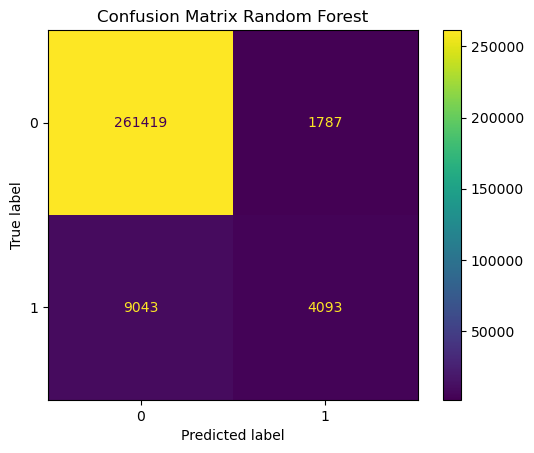

In [15]:
cm = ConfusionMatrixDisplay(np.array([[261419, 1787],
       [9043,  4093]]))
cm.plot()
plt.title('Confusion Matrix Random Forest')
plt.show()

In [43]:
model_SMEs_rf_os_istat_noval

Pipeline(steps=[('model', RandomForestClassifier())])

In [44]:
feature_names_SMEs_rf_istat_noval = [col for col in os_X_train_SMEs_istat.columns]
importances_SMEs_rf_istat_noval = model_SMEs_rf_os_istat_noval['model'].feature_importances_

forest_importances_SMEs_rf_istat_noval = pd.Series(importances_SMEs_rf_istat_noval, index=feature_names_SMEs_rf_istat_noval)

forest_importances_SMEs_rf_istat_noval.sort_values(ascending=False).to_dict()

{'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.037606021005842795,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.034985163629703414,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 1': 0.03213356307045367,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.026463500159207006,
 'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1': 0.026157373958834936,
 'Rapporto di indebitamento\nAnno - 1': 0.023378133617949316,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.02249794731156838,
 'Dipendenti\nAnno - 1': 0.01901306841519311,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 2': 0.013893174658814551,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.012818494385790828,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 2': 0.012108644240843134,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2': 0.011349947551075374,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 3': 0.011041513616461978,
 'Margine

In [45]:
accuracy_SMEs_gb_os_istat_noval, cm_SMEs_gb_os_istat_noval, model_SMEs_gb_os_istat_noval = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs_istat,
    y_train=os_y_train_SMEs_istat,
    X_test=X_test_SMEs_istat_v2,
    y_test=y_test_SMEs_istat_v2,
    model=GradientBoostingClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [46]:
accuracy_SMEs_gb_os_istat_noval

0.9449088448371945

In [47]:
cm_SMEs_gb_os_istat_noval

array([[255373,   7833],
       [  7391,   5745]], dtype=int64)

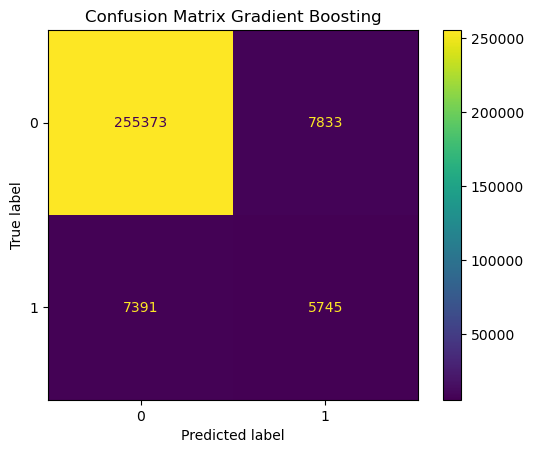

In [48]:
cm = ConfusionMatrixDisplay(np.array([[255373, 7833],
       [7391, 5745]]))
cm.plot()
plt.title('Confusion Matrix Gradient Boosting')
plt.show()

In [49]:
model_SMEs_gb_os_istat_noval

Pipeline(steps=[('model', GradientBoostingClassifier())])

In [50]:
feature_names_SMEs_gb_istat_noval = [col for col in os_X_train_SMEs_istat.columns]
importances_SMEs_gb_istat_noval = model_SMEs_gb_os_istat_noval['model'].feature_importances_

forest_importances_SMEs_gb_istat_noval = pd.Series(importances_SMEs_gb_istat_noval, index=feature_names_SMEs_gb_istat_noval)

forest_importances_SMEs_gb_istat_noval.sort_values(ascending=False).to_dict()

{'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.28236211282764084,
 'No of companies in corporate group': 0.1065533754164585,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.07294352138834435,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.06287437733016313,
 'Dipendenti\nAnno - 1': 0.058154185987893924,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.05735211877656979,
 'Rapporto di indebitamento\nAnno - 1': 0.03034967813103065,
 'Capitale sociale (EUR)': 0.027048609613217634,
 'ITA_LC_2020_2021_margine operativo lordo (migliaia di euro)': 0.022734700639810174,
 '2018_2019_investimenti lordi in beni materiali (migliaia di euro)': 0.02126324110450637,
 '2019_2020_margine operativo lordo (migliaia di euro)': 0.01631030371964515,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.016244821990794252,
 'ITA_LC_2020_2021_acquisto di beni e servizi (migliaia di euro)': 0.013786301046779508,
 '2019_2020_occupati': 0.011684613

In [51]:
features_importance_rf_SMEs_istat, results_rf_SMEs_istat = run_model(os_X_train_SMEs_istat, os_y_train_SMEs_istat, X_test_SMEs_istat_v2, y_test_SMEs_istat_v2, model=RandomForestClassifier())

In [52]:
features_importance_rf_SMEs_istat

{'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.04024869086443931,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.029002866597564587,
 'Rapporto di indebitamento\nAnno - 1': 0.02731144381995075,
 'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1': 0.027123810940618585,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.024387101392243583,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.02299386754903587,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 2': 0.016697949621165734,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 2': 0.01450127925102585,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 1': 0.014378000067796938,
 'Dipendenti\nAnno - 1': 0.014223496912338944,
 'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 2': 0.014217155011723017,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.013245511337700295,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 1': 0.012756884721300652

In [53]:
results_rf_SMEs_istat

{'Accuracy': 0.8109356718092229,
 'Confusion Matrix': array([[128285,  29713],
        [  1635,   6173]], dtype=int64),
 'Threshold': 0.13,
 'tpr': array([0.00000000e+00, 5.63063063e-04, 1.50150150e-03, 3.19069069e-03,
        5.25525526e-03, 1.16366366e-02, 1.52027027e-02, 1.87687688e-02,
        2.45870871e-02, 2.83408408e-02, 3.22822823e-02, 3.82882883e-02,
        4.54204204e-02, 5.01126126e-02, 5.55555556e-02, 6.38138138e-02,
        7.26351351e-02, 8.08933934e-02, 8.91516517e-02, 9.62837838e-02,
        1.04542042e-01, 1.12987988e-01, 1.19932432e-01, 1.27252252e-01,
        1.33070571e-01, 1.40953453e-01, 1.50150150e-01, 1.58408408e-01,
        1.63100601e-01, 1.69481982e-01, 1.76426426e-01, 1.82620120e-01,
        1.89564565e-01, 1.96509009e-01, 2.04954955e-01, 2.12274775e-01,
        2.19406907e-01, 2.24849850e-01, 2.30855856e-01, 2.39677177e-01,
        2.46246246e-01, 2.53190691e-01, 2.58445946e-01, 2.64451952e-01,
        2.71959459e-01, 2.77965465e-01, 2.85097598e-01, 2.912

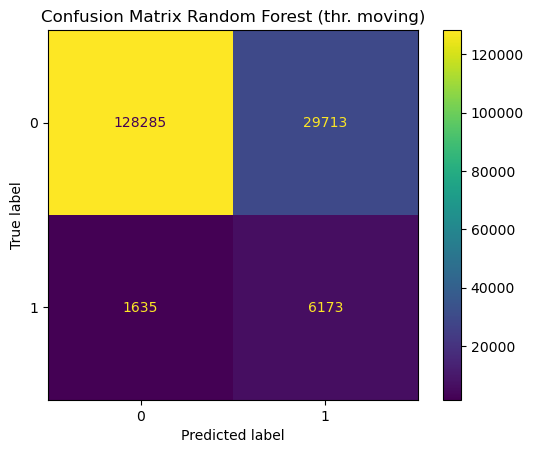

In [14]:
cm = ConfusionMatrixDisplay(np.array([[128285, 29713],
        [1635, 6173]]))
cm = cm.plot(values_format='')
plt.title('Confusion Matrix Random Forest (thr. moving)')
plt.show()

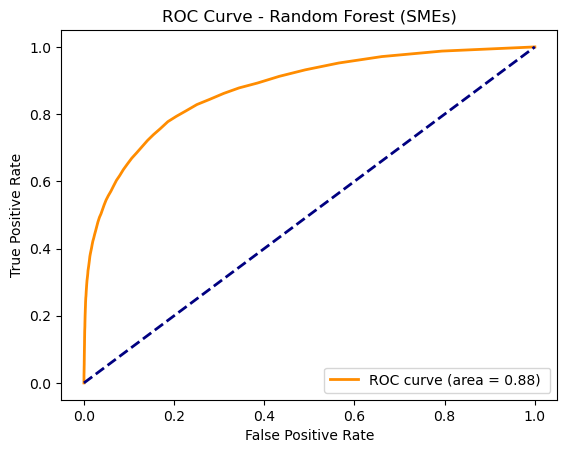

In [55]:
plot_roc_curve(results_rf_SMEs_istat['fpr'], results_rf_SMEs_istat['tpr'], results_rf_SMEs_istat['auc'], model_name = 'Random Forest (SMEs)')

In [56]:
features_importance_gb_SMEs_istat, results_gb_SMEs_istat = run_model(os_X_train_SMEs_istat, os_y_train_SMEs_istat, X_test_SMEs_istat_v2, y_test_SMEs_istat_v2, model=GradientBoostingClassifier())

In [57]:
features_importance_gb_SMEs_istat

{'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.28236211282754675,
 'No of companies in corporate group': 0.10655337541648632,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.07294352138797396,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.06287437733049005,
 'Dipendenti\nAnno - 1': 0.05815418598792045,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.05735211877665935,
 'Rapporto di indebitamento\nAnno - 1': 0.03034967813089171,
 'Capitale sociale (EUR)': 0.02704860961326863,
 'ITA_LC_2020_2021_margine operativo lordo (migliaia di euro)': 0.02273470063981126,
 '2018_2019_investimenti lordi in beni materiali (migliaia di euro)': 0.021263241104590082,
 '2019_2020_margine operativo lordo (migliaia di euro)': 0.01631030371964,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.016244821990840628,
 'ITA_LC_2020_2021_acquisto di beni e servizi (migliaia di euro)': 0.013786301046693388,
 '2019_2020_occupati': 0.0116846134857

In [58]:
results_gb_SMEs_istat

{'Accuracy': 0.795369286998058,
 'Confusion Matrix': array([[125627,  32338],
        [  1591,   6250]], dtype=int64),
 'Threshold': 0.18809975002556592,
 'tpr': array([0.00000000e+00, 1.88857413e-04, 1.88857413e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'fpr': array([0.00000000e+00, 0.00000000e+00, 9.50200017e-06, ...,
        9.99249342e-01, 9.99268346e-01, 1.00000000e+00]),
 'auc': 0.8763228459874091}

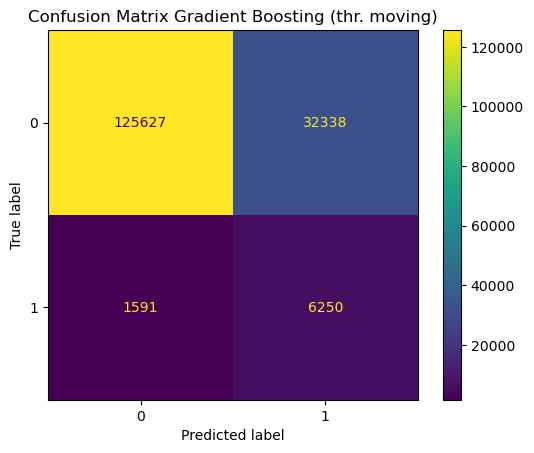

In [52]:
cm = ConfusionMatrixDisplay(np.array(([[125627, 32338],
        [1591, 6250]])))
cm.plot()
plt.title('Confusion Matrix Gradient Boosting (thr. moving)')
plt.show()

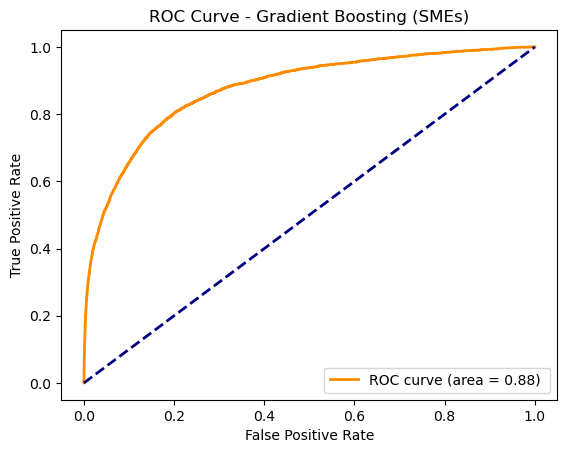

In [60]:
plot_roc_curve(results_gb_SMEs_istat['fpr'], results_gb_SMEs_istat['tpr'], results_gb_SMEs_istat['auc'], model_name = 'Gradient Boosting (SMEs)')